In [1]:
require(dplyr)
require(scales)
require(tidyverse)

d <- read.csv("comb-data.csv")
d$coverage_inc <- d$edges_covered - d$initial_coverage
# d$cif <- factor(d$coverage_inc, ordered=TRUE)
static_cols <- c("total_shared", "total_eq", "total_ineq", "total_indir", "bin_text_size")

statics <- na.omit(unique(d[c(static_cols, c("benchmark"))]))

d <- d %>% filter(benchmark != "lcms-2017-03-21")
cols <- c("benchmark", "fuzzer", "corpus_size",
                "initial_coverage", "ineq_reached", "ineq_unexplored",
                "indir_reached", "shared_reached", "mean_exec_ns",
                "mean_size_bytes", "coverage_inc", "eq_reached", "eq_unexplored", "edges_covered")
d <- d[cols]
d$mean_exec_ms = d$mean_exec_ns / 1000000

d$ineq_unex_perc <- d$ineq_unexplored / d$initial_coverage

scaled_d <- d %>%
    mutate_if(is.numeric, rescale)
scaled_d$coverage_inc <- d$coverage_inc 
scaled_d <- scaled_d %>% drop_na() %>% as.data.frame


d_statics <- merge(x = d, y = statics, by = "benchmark", all.x = TRUE)
mec <- d %>% group_by(benchmark) %>% summarise(max(edges_covered))
d_statics <- merge(x = d_statics, y = mec, by = "benchmark", all.x = TRUE)
head(d_statics)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: scales

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



,benchmark,fuzzer,corpus_size,initial_coverage,ineq_reached,ineq_unexplored,indir_reached,shared_reached,mean_exec_ns,mean_size_bytes,⋯,eq_unexplored,edges_covered,mean_exec_ms,ineq_unex_perc,total_shared,total_eq,total_ineq,total_indir,bin_text_size,max(edges_covered)
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,bloaty_fuzz_target,afl,NA,6261,NA,NA,NA,NA,NA,NA,⋯,NA,6968,NA,NA,5358,48128,17613,2283,8835,7403
2,bloaty_fuzz_target,entropic,213,6523,2185,1618,72,0,10110806,21224.643,⋯,2098,7172,10.110806,0.2480454,5358,48128,17613,2283,8835,7403
3,bloaty_fuzz_target,entropic,71,5423,1625,1223,58,0,10180785,7671.028,⋯,1979,6610,10.180785,0.2255209,5358,48128,17613,2283,8835,7403
4,bloaty_fuzz_target,libfuzzer,12,4533,1224,990,50,0,7566192,2569.667,⋯,1713,6074,7.566192,0.2183984,5358,48128,17613,2283,8835,7403
5,bloaty_fuzz_target,aflplusplus,213,6523,2185,1618,72,0,10110806,21224.643,⋯,2098,7349,10.110806,0.2480454,5358,48128,17613,2283,8835,7403
6,bloaty_fuzz_target,aflplusplus,71,5423,1625,1223,58,0,10180785,7671.028,⋯,1979,6969,10.180785,0.2255209,5358,48128,17613,2283,8835,7403


In [60]:
ranks = c()

ranker = function(d) {
d <- d %>% drop_na()
for (rown in 1:nrow(d)) {
    rank = NA
    for (rown_inner in 1:nrow(d)) {
        if (d[rown, "initial_coverage"] == d[rown_inner, "initial_coverage"] &&
            d[rown, "corpus_size"] == d[rown_inner, "corpus_size"] &&
            d[rown, "benchmark"] == d[rown_inner, "benchmark"] &&
            d[rown, "fuzzer"] != d[rown_inner, "fuzzer"]) {
            if (is.na(rank)) {
                rank <- 1
            }
            if (d[rown, "coverage_inc"] < d[rown_inner, "coverage_inc"]) {
                rank <- rank + 1
            }
        }
    }
    ranks[rown] = rank
}
    ranks
}
ranks <- ranker(d)
d$per_trial_ranks <- factor(ranks, ordered=TRUE)
d$per_trial_ranks_numeric <- ranks

ranks <- ranker(scaled_d)
scaled_d$per_trial_ranks <- factor(ranks, ordered=TRUE)
scaled_d$per_trial_ranks_numeric <- ranks




`geom_smooth()` using formula 'y ~ x'

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 10. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 475 rows containing missing values (geom_point).”


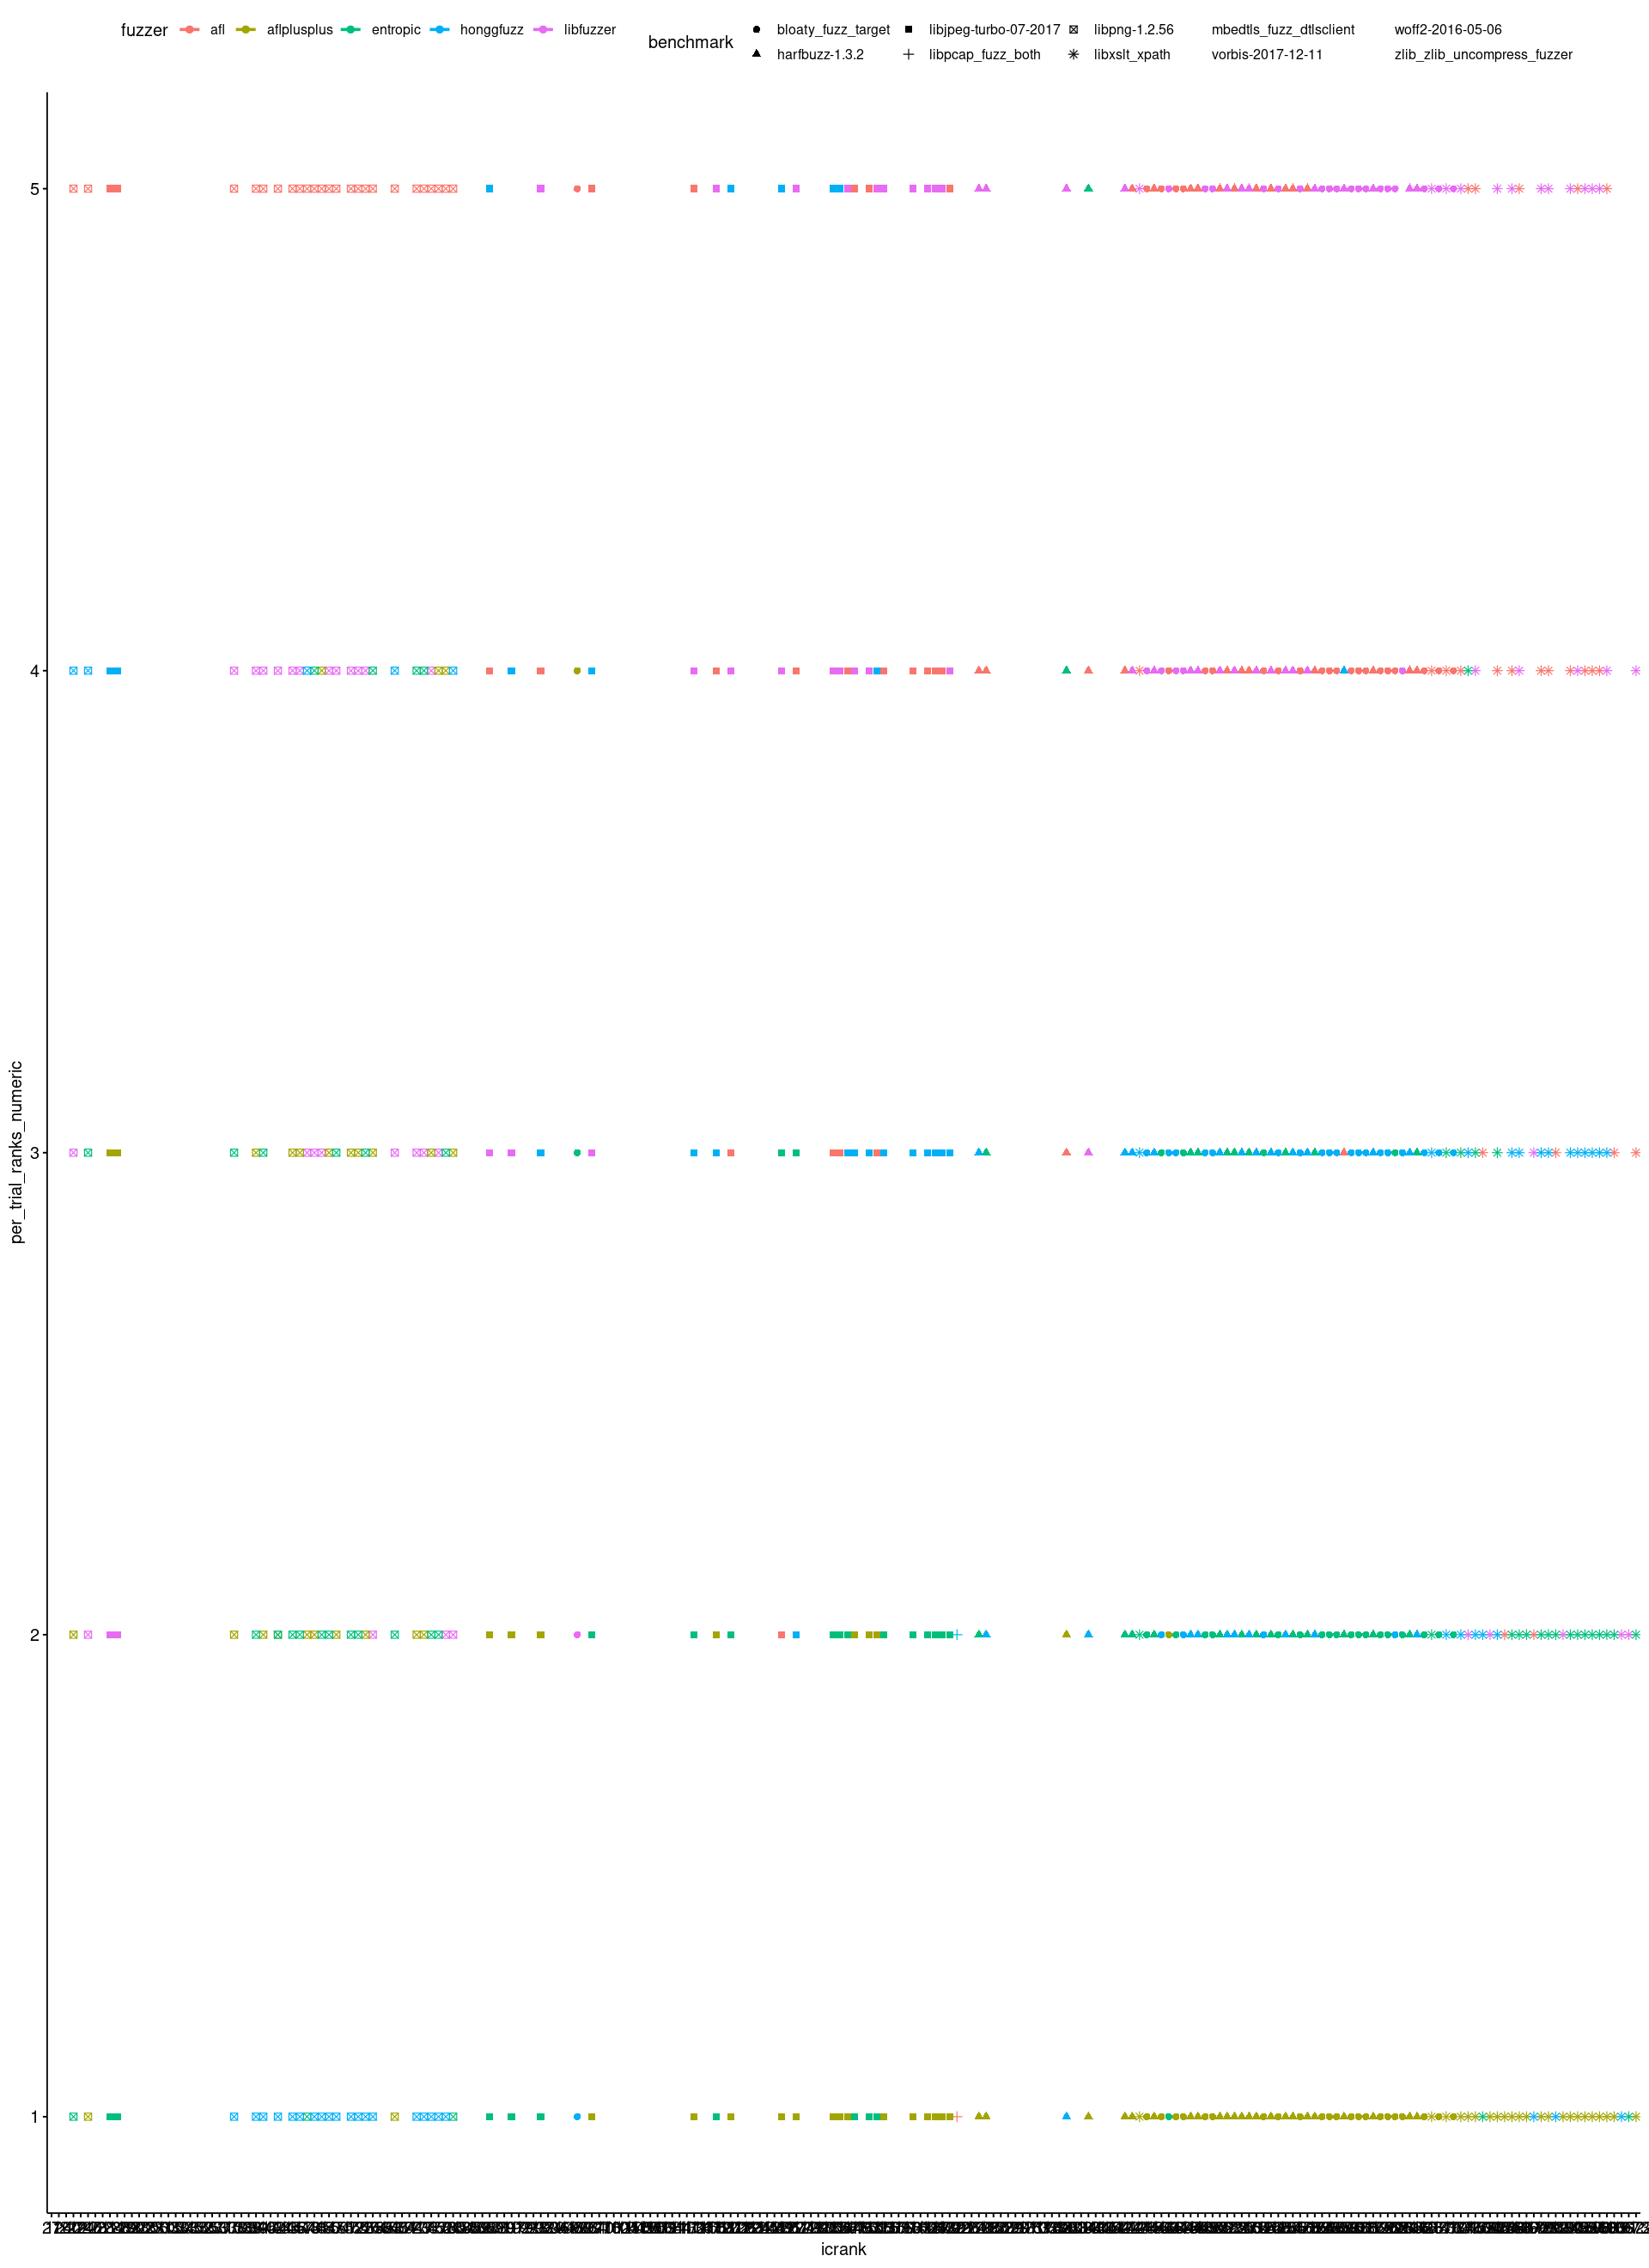

In [53]:
library(ggpubr)



options(repr.plot.width=16, repr.plot.height=22)
d$icrank <- factor(d$initial_coverage, ordered=TRUE)

ggscatter(
  d, x = "icrank", y = "per_trial_ranks_numeric",
  color = "fuzzer", shape="benchmark", add = "reg.line")
# + facet_wrap(benchmark ~ ., scales = "free", ncol=3)


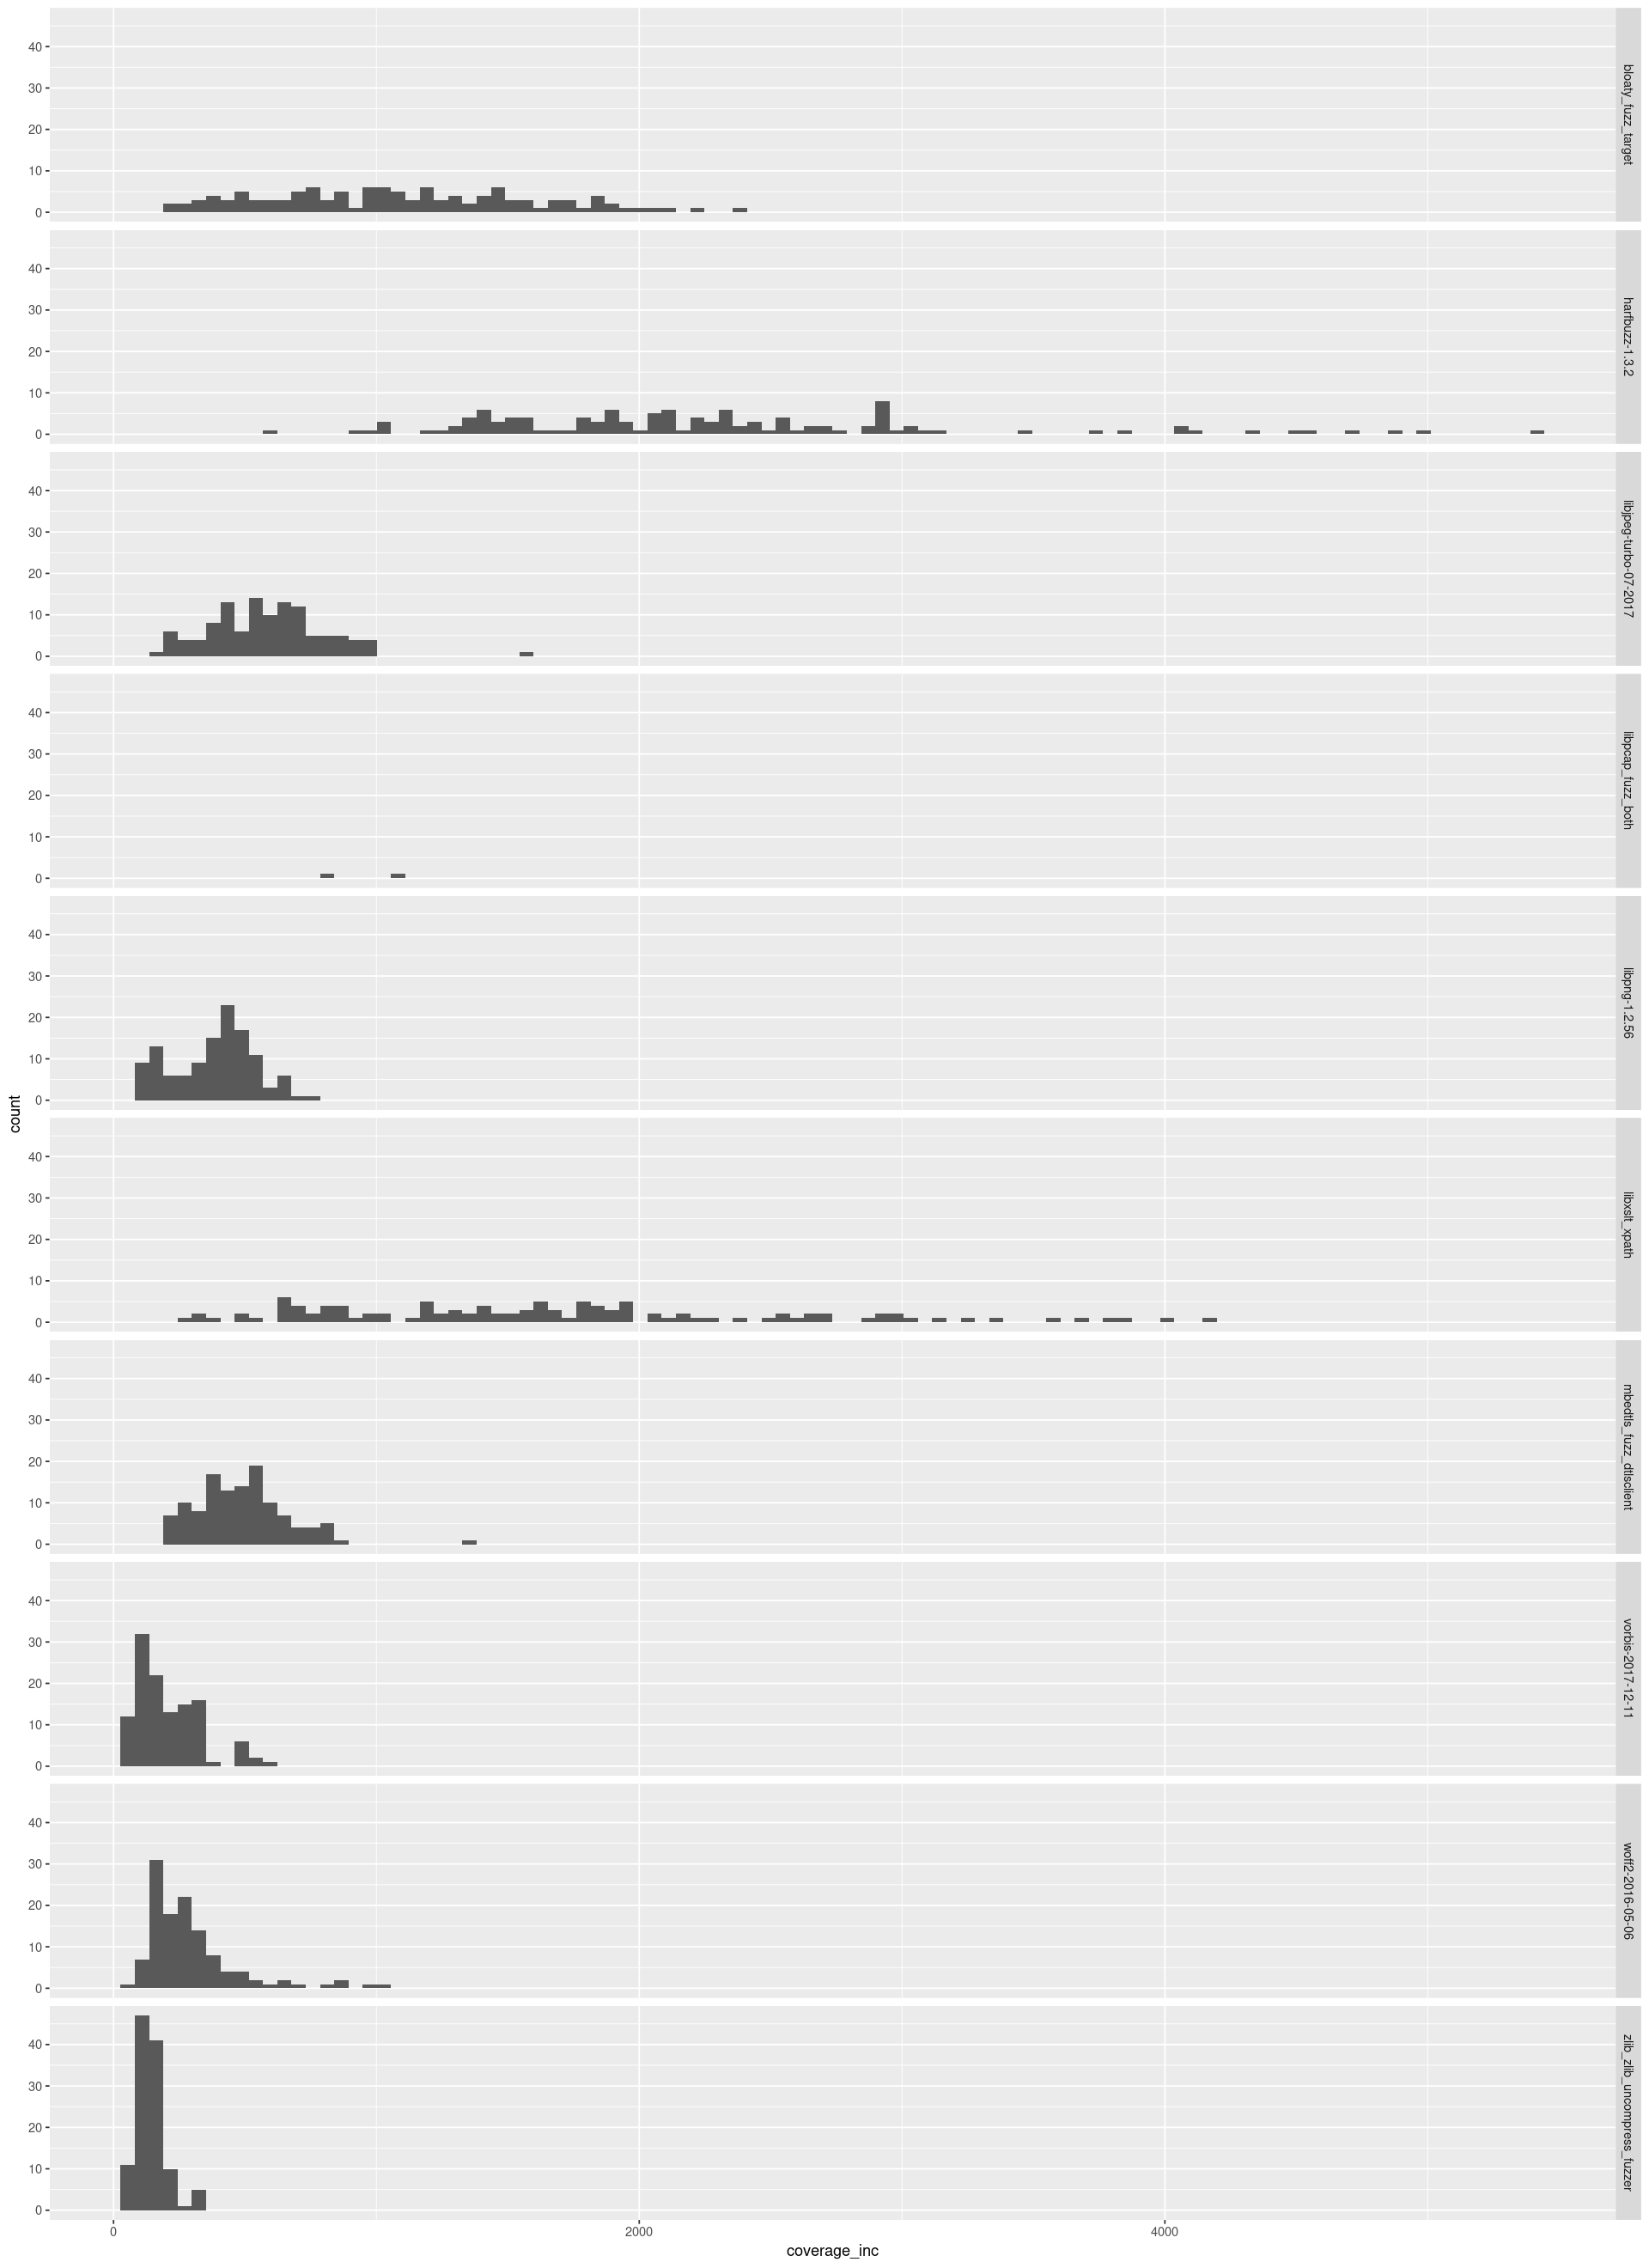

In [22]:
library("ggplot2")

ggp <- ggplot(d, aes(coverage_inc)) + geom_histogram(bins=100)
ggp + facet_grid(benchmark ~ .) 

`geom_smooth()` using formula 'y ~ x'



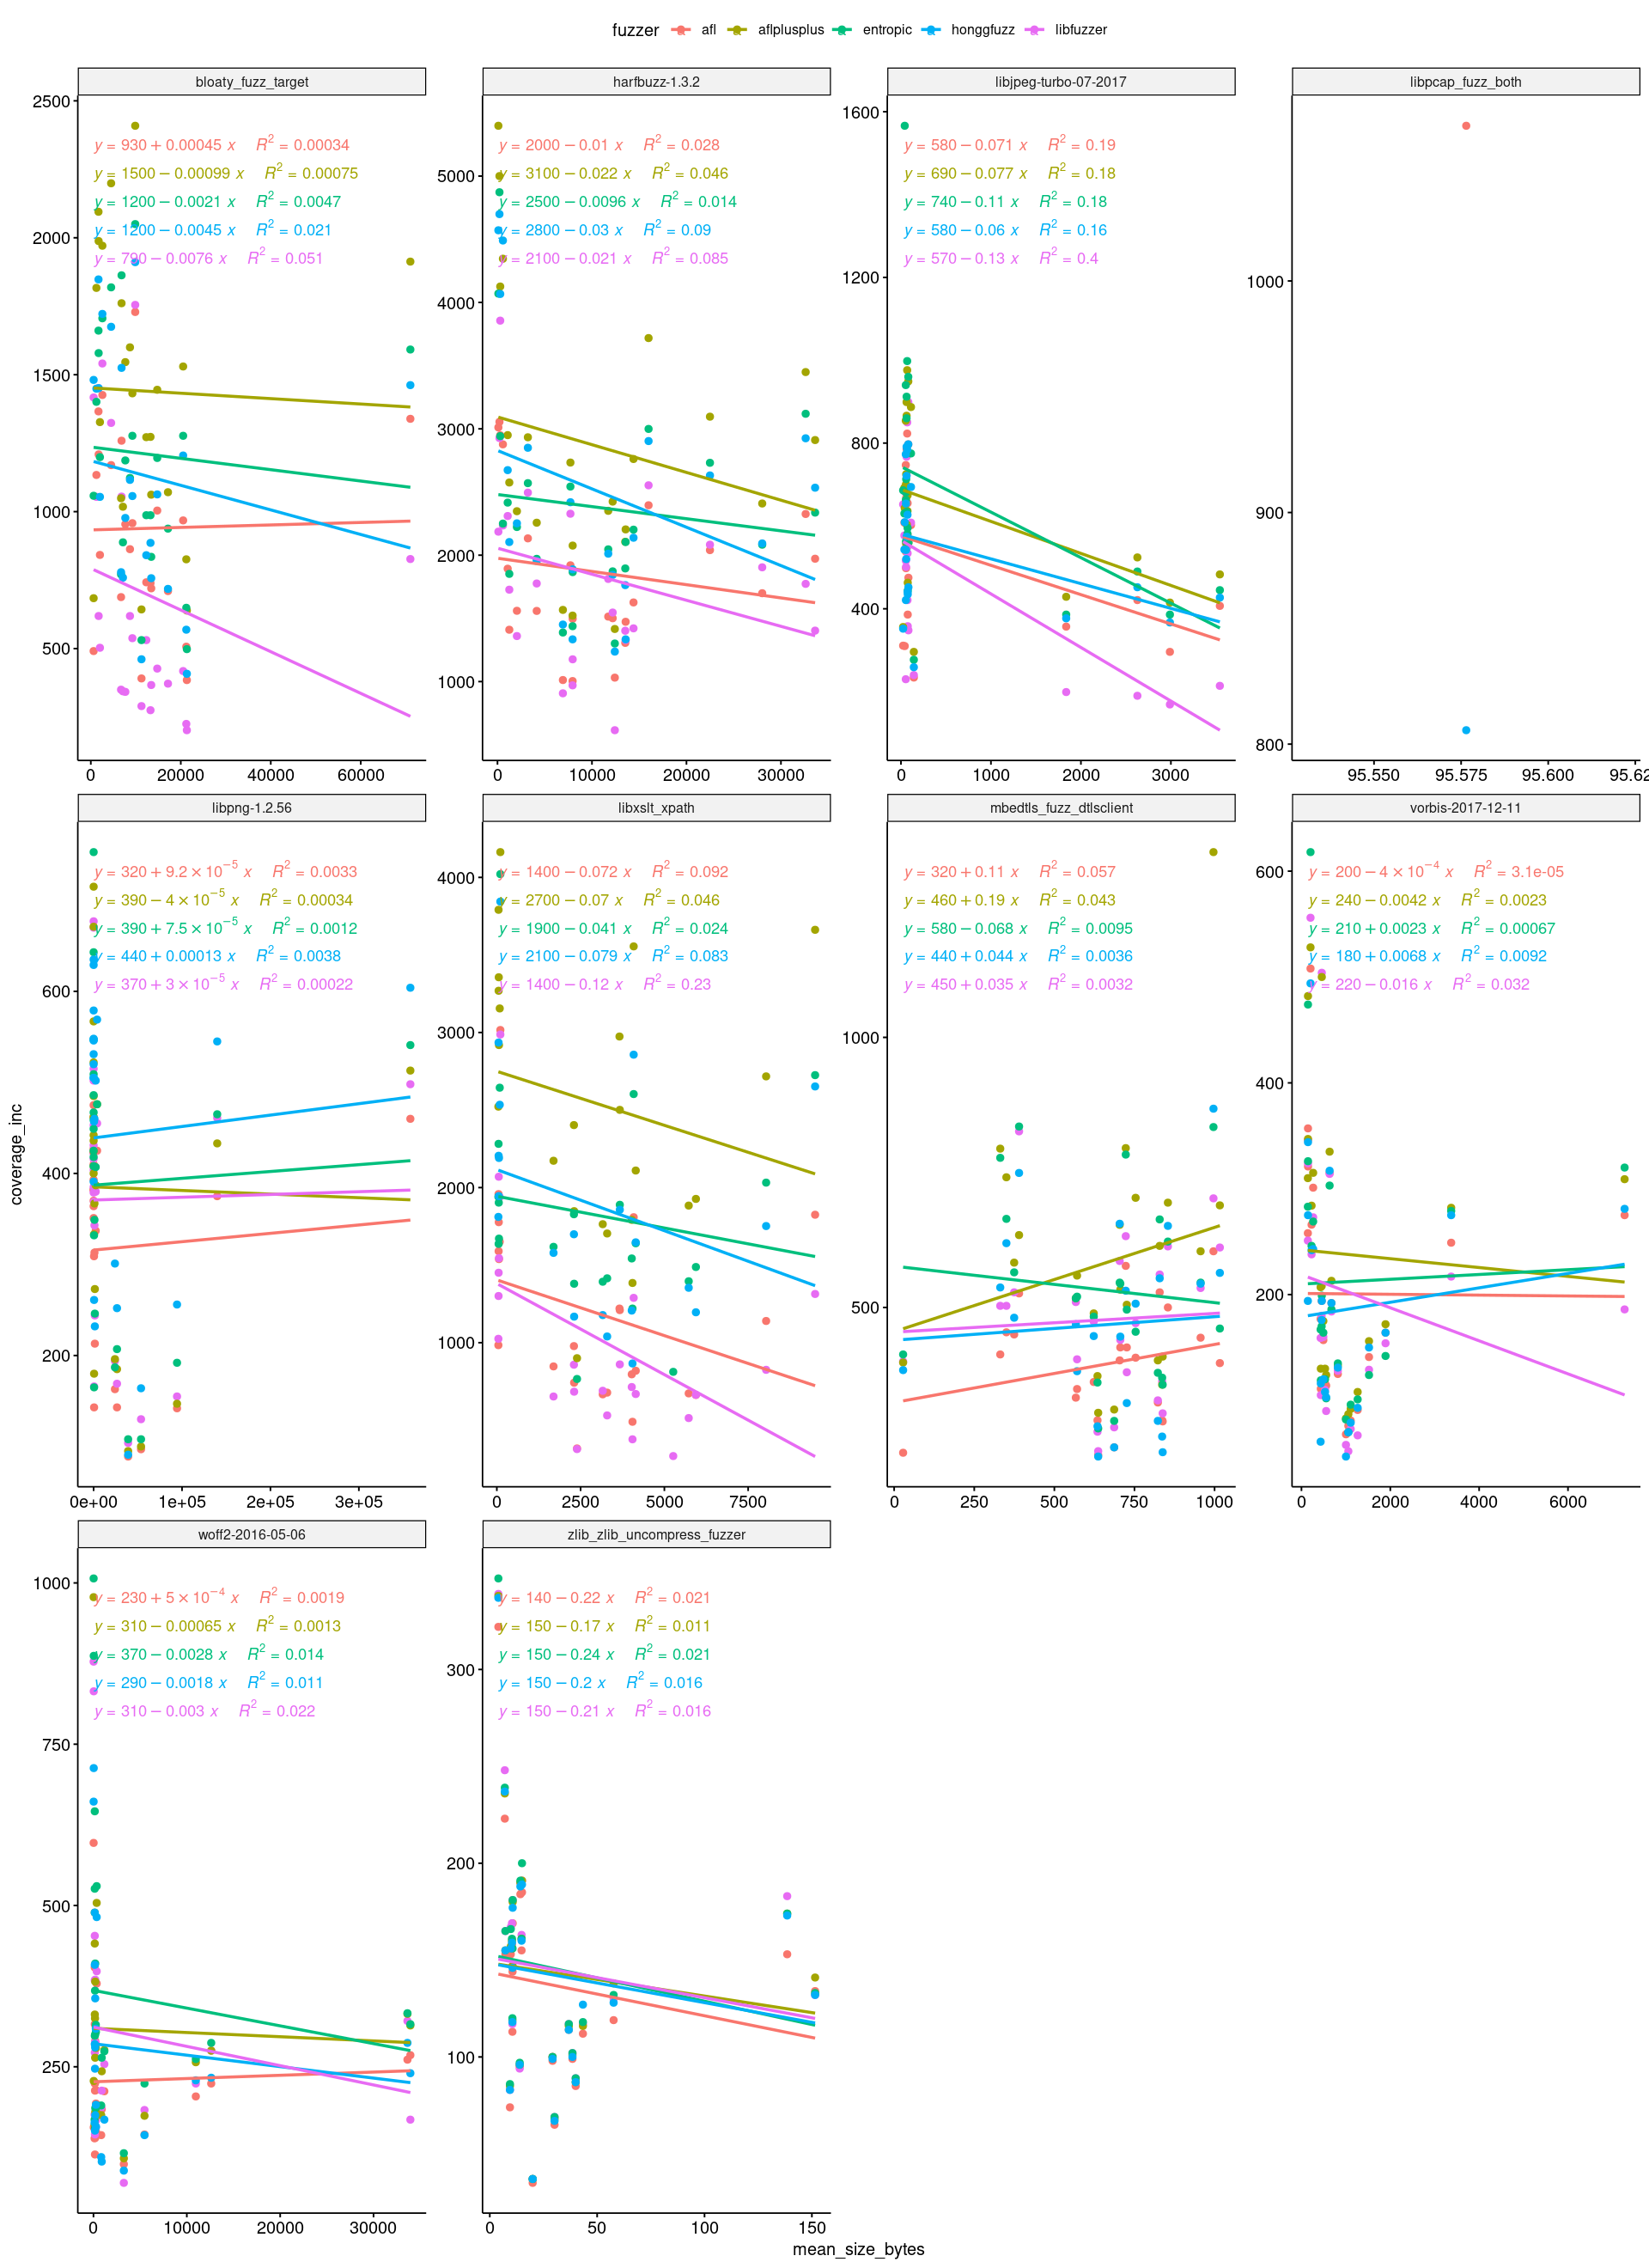

In [49]:
library(ggpubr)



options(repr.plot.width=16, repr.plot.height=22)

ggscatter(
  d, x = "mean_size_bytes", y = "coverage_inc",
  color = "fuzzer", add = "reg.line") + stat_regline_equation(
      aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)) + facet_wrap(benchmark ~ ., scales="free")

`geom_smooth()` using formula 'y ~ x'



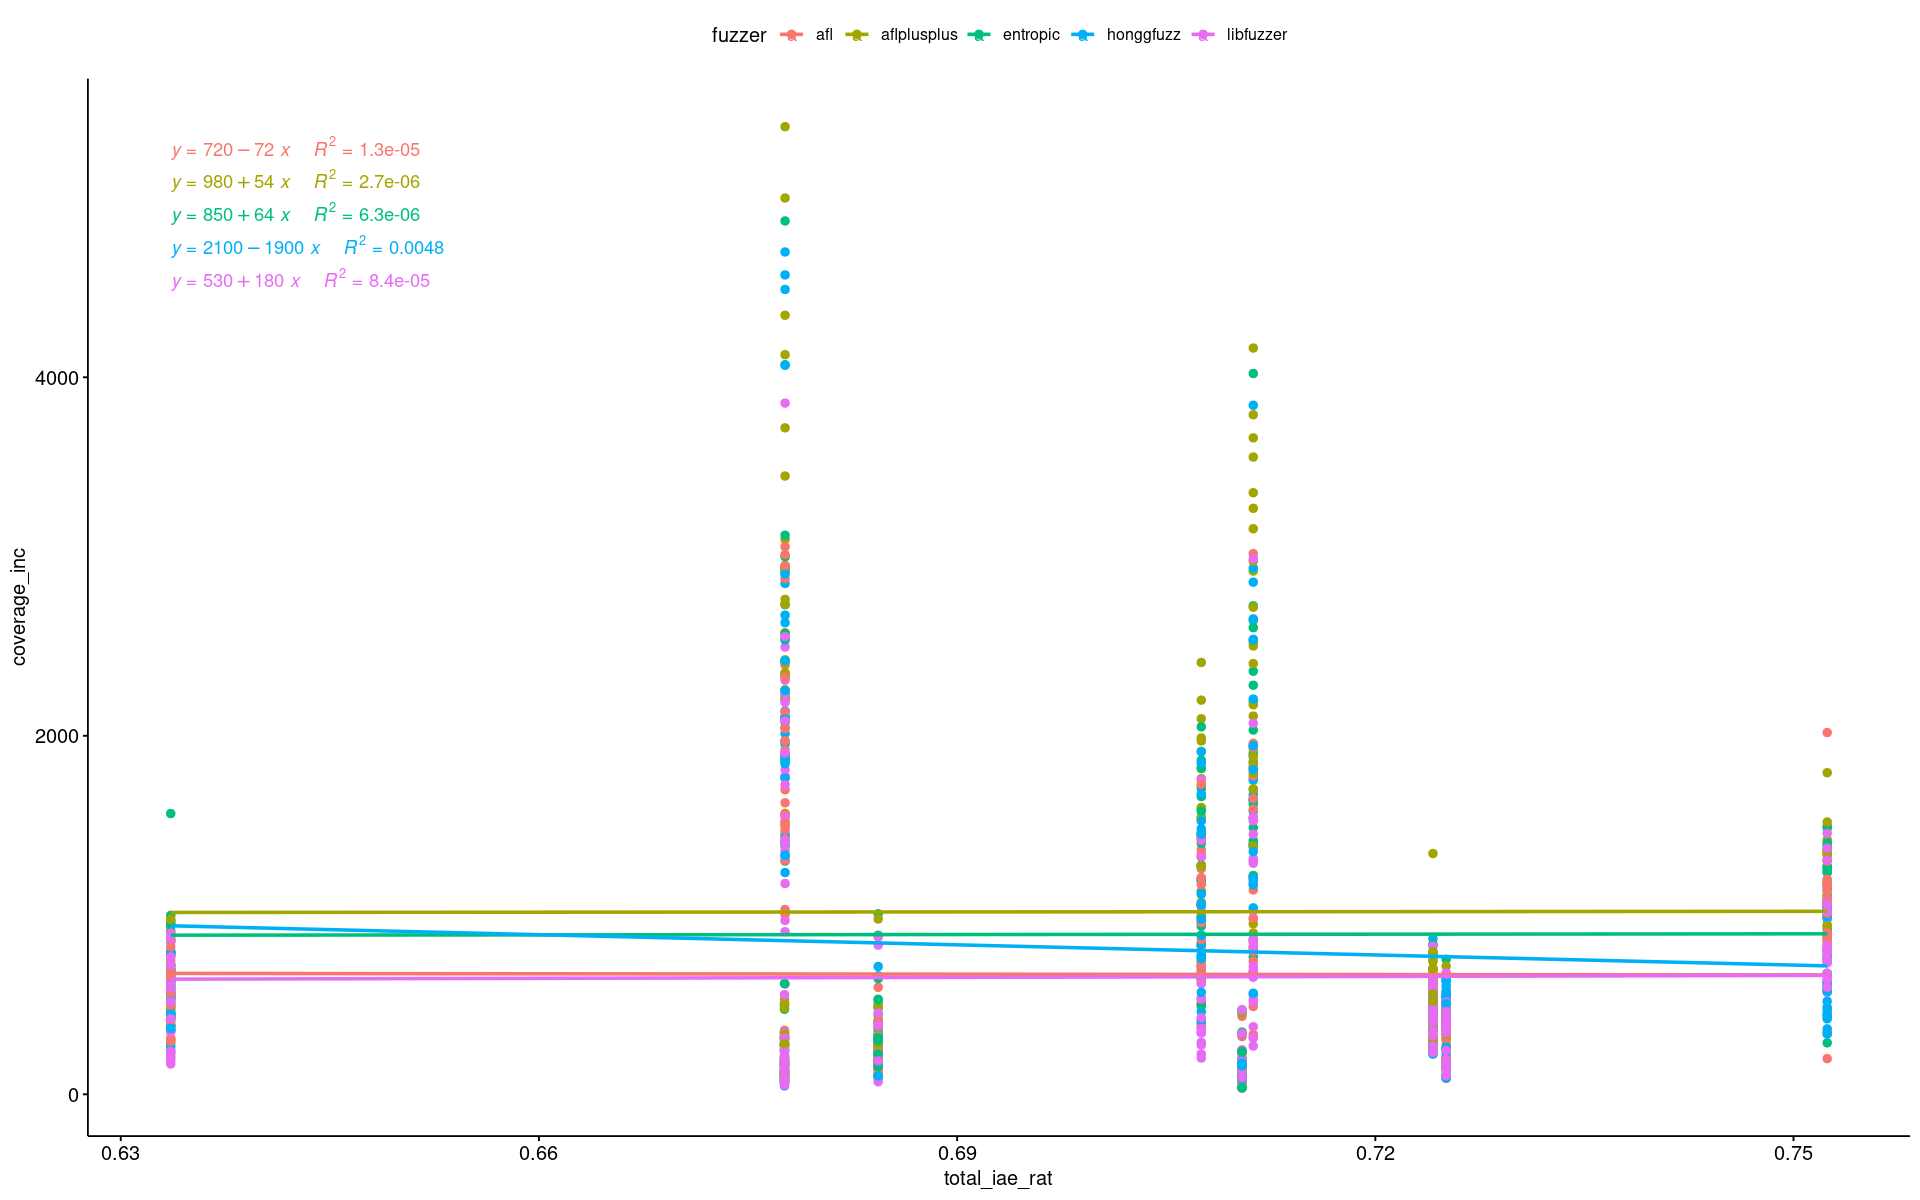

In [54]:
library(ggpubr)

d_statics$total_ie_rat <- d_statics$total_ineq / d_statics$total_eq
d_statics$approx_edges <-  (d_statics$total_eq + d_statics$total_ineq + d_statics$total_indir)
d_statics$total_iae_rat <- d_statics$total_eq / d_statics$approx_edges
d_statics$total_ib_rat <- d_statics$total_indir / d_statics$bin_text_size


ggscatter(
  d_statics, x = "total_iae_rat", y = "coverage_inc",
  color = "fuzzer", add = "reg.line") + stat_regline_equation(
      aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)) 

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning

Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containin

Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 5 rows containing missing values”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, y, method = method, use = use):
“Cannot compute e

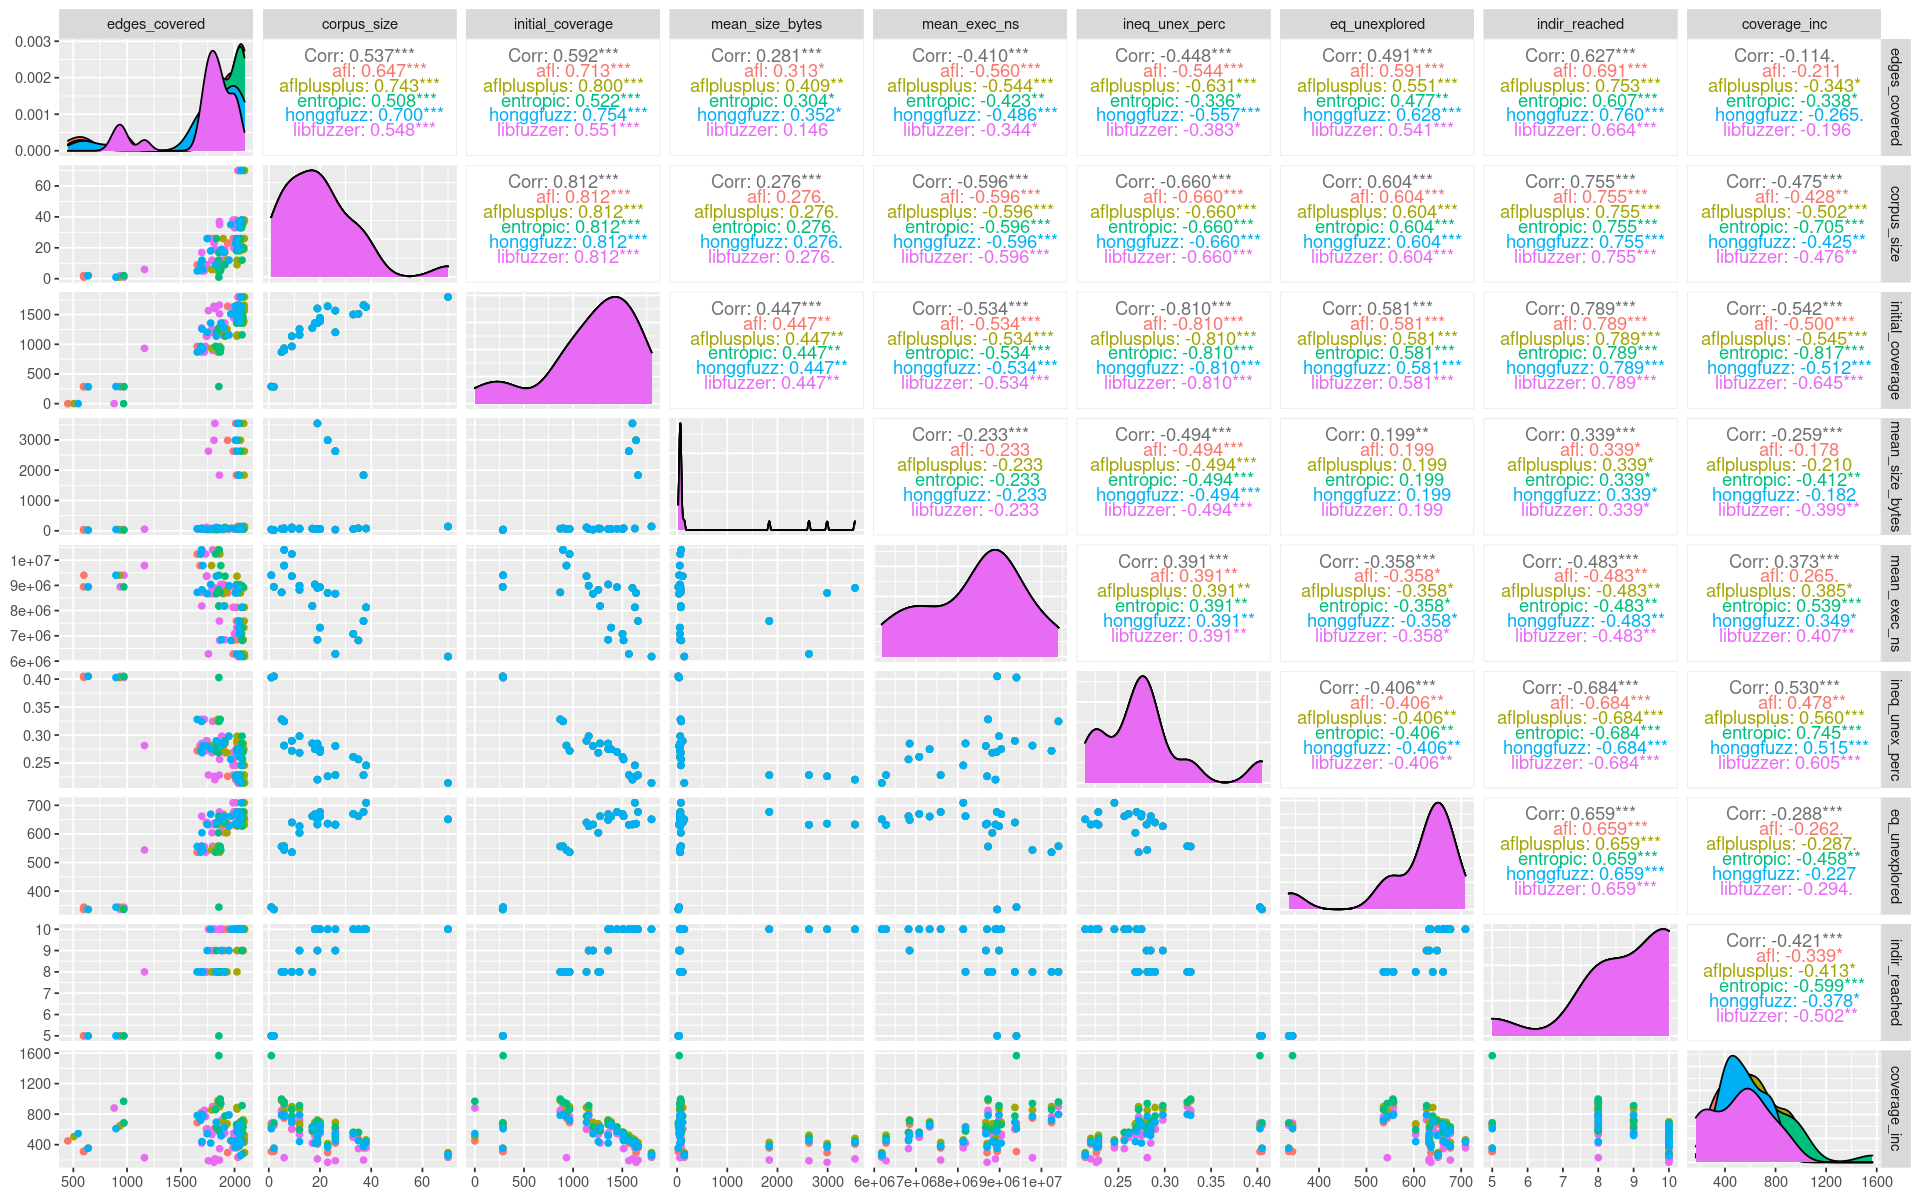

In [22]:
# install.packages("GGally")

library(GGally)
library(repr)

options(repr.plot.width=16, repr.plot.height=10)
vars = c("edges_covered", "corpus_size", "initial_coverage", "mean_size_bytes", "mean_exec_ns", "ineq_unex_perc", "eq_unexplored", "indir_reached", "coverage_inc" )

# display a pairplot of all four columns of data
GGally::ggpairs(d %>% filter(benchmark == "libjpeg-turbo-07-2017"), columns = vars, ggplot2::aes(color = fuzzer), upper = list(continuous = wrap("cor", method = "kendall")))

In [ ]:
# install.packages("tidyverse")
# install.packages("ggpubr")
# install.packages("rstatix")
# install.packages("broom")
library(tidyverse)
library(rstatix)
library(broom)

In [ ]:
library(ggpubr)
# Assumption 1 (ANCOVA): Visually check for  linear relationship between covariate and output 
ggscatter(
  d[d$benchmark == "bloaty_fuzz_target",], x = "ineq_unexplored", y = "coverage_inc",
  color = "fuzzer", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = fuzzer)
    )


In [ ]:
sample_fb <- read.csv("sample-report.csv")
require(dplyr)
max <- sample_fb %>% group_by(trial_id) %>% summarise(edges_covered = max(edges_covered))
max <- unique(left_join(max, sample_fb[c("trial_id", "benchmark", "fuzzer")], by = c("trial_id")))

norm_tests <- aggregate(formula = edges_covered ~ benchmark + fuzzer,
          data = max,
          FUN = function(x) { tryCatch({
              y <- shapiro.test(x); c(y$statistic, y$p.value)
            }, error = function(e) {
               c(0,0)
            }
          )})
norm_tests

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




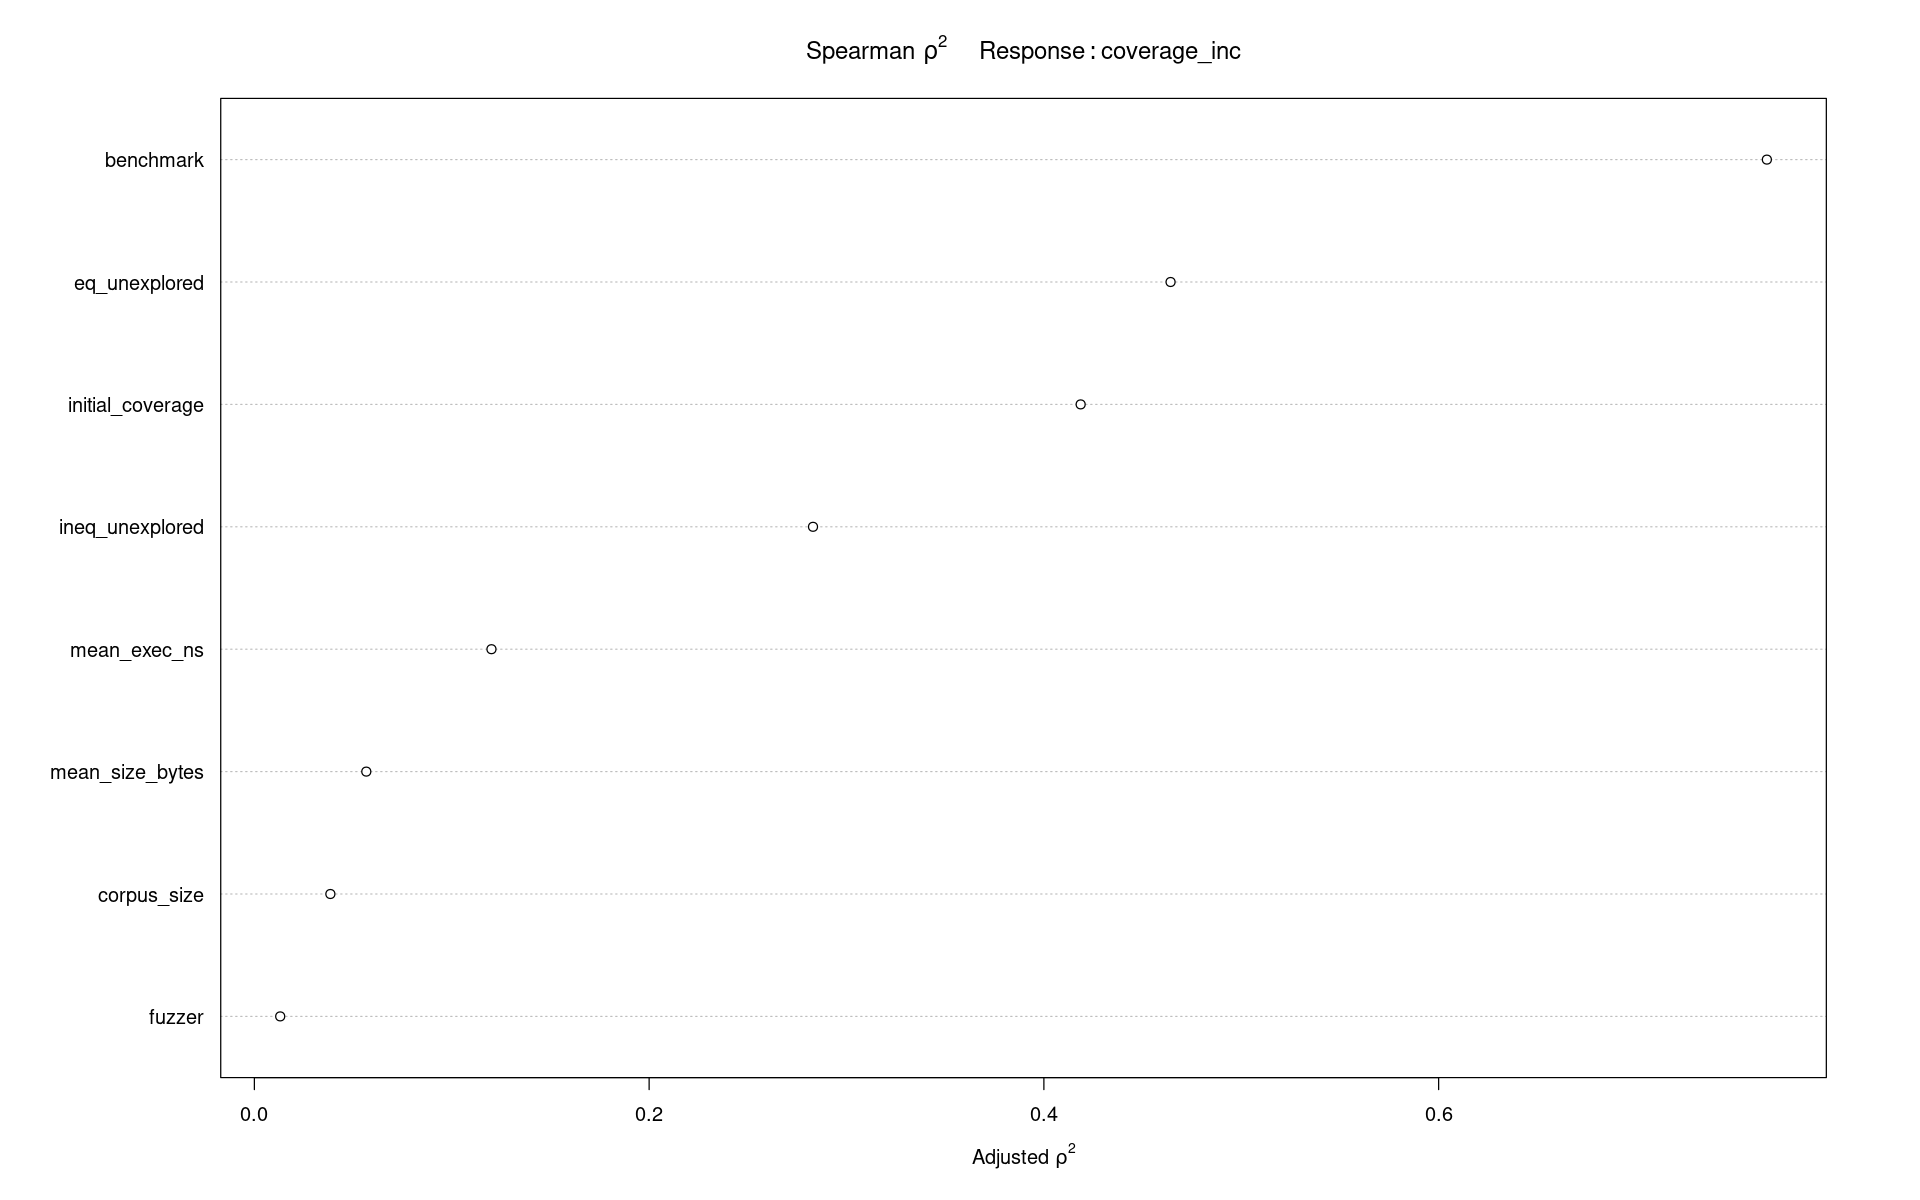

In [15]:
library("rms")

rms_d <- d

s <- spearman2(coverage_inc ~ corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + benchmark, data=rms_d)
plot(s)

In [ ]:
v <- varclus(~ corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + benchmark, data=rms_d)
plot(v)

In [ ]:
require("rms")

model <- orm(formula = coverage_inc ~ benchmark + fuzzer + initial_coverage, data = d)
model
AIC(model)

In [55]:
require(dplyr)
require(purrr)
require(plyr)



corellation <- function(y, x) {
    t <- cor.test(y, x, method = "spearman")
  
    if (is.finite(t$p.value)) {

        t$estimate
    } else {
        rv <- NA
        names(rv)[0] <- "rho"
        rv
    }
}

acc_coefs <- function(f, notused) { 
    g <- f %>% group_by(benchmark) %>%
        group_map(
            ~ c(corellation(.x$corpus_size, .x$initial_coverage), .x$benchmark[1]),
            .keep = TRUE
        ) %>% bind_rows()

    g
}

res <- d %>% group_by(fuzzer) %>%
        group_map(
            ~ acc_coefs(.x, 0) %>% add_column(fuzz = .x$fuzzer[1]),
            .keep = TRUE
        ) %>% bind_rows() 

names(res)[2] <- 'bench'
res$rho <- as.numeric(res$rho)
res



Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following object is masked from ‘package:purrr’:

    compact


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(y, x, method = "spearman"):
“Cannot compute exact p-value with ties”
Warni

rho,bench,fuzz
<dbl>,<chr>,<chr>
0.9846763,bloaty_fuzz_target,afl
0.9702109,harfbuzz-1.3.2,afl
0.9139050,libjpeg-turbo-07-2017,afl
0.8921739,libpcap_fuzz_both,afl
0.9562389,libpng-1.2.56,afl
0.9910850,libxslt_xpath,afl
0.9669422,mbedtls_fuzz_dtlsclient,afl
0.9921706,vorbis-2017-12-11,afl
0.9440942,woff2-2016-05-06,afl


Warning message:
“Removed 20 rows containing missing values (geom_bar).”
Warning message:
“Removed 20 rows containing missing values (geom_bar).”


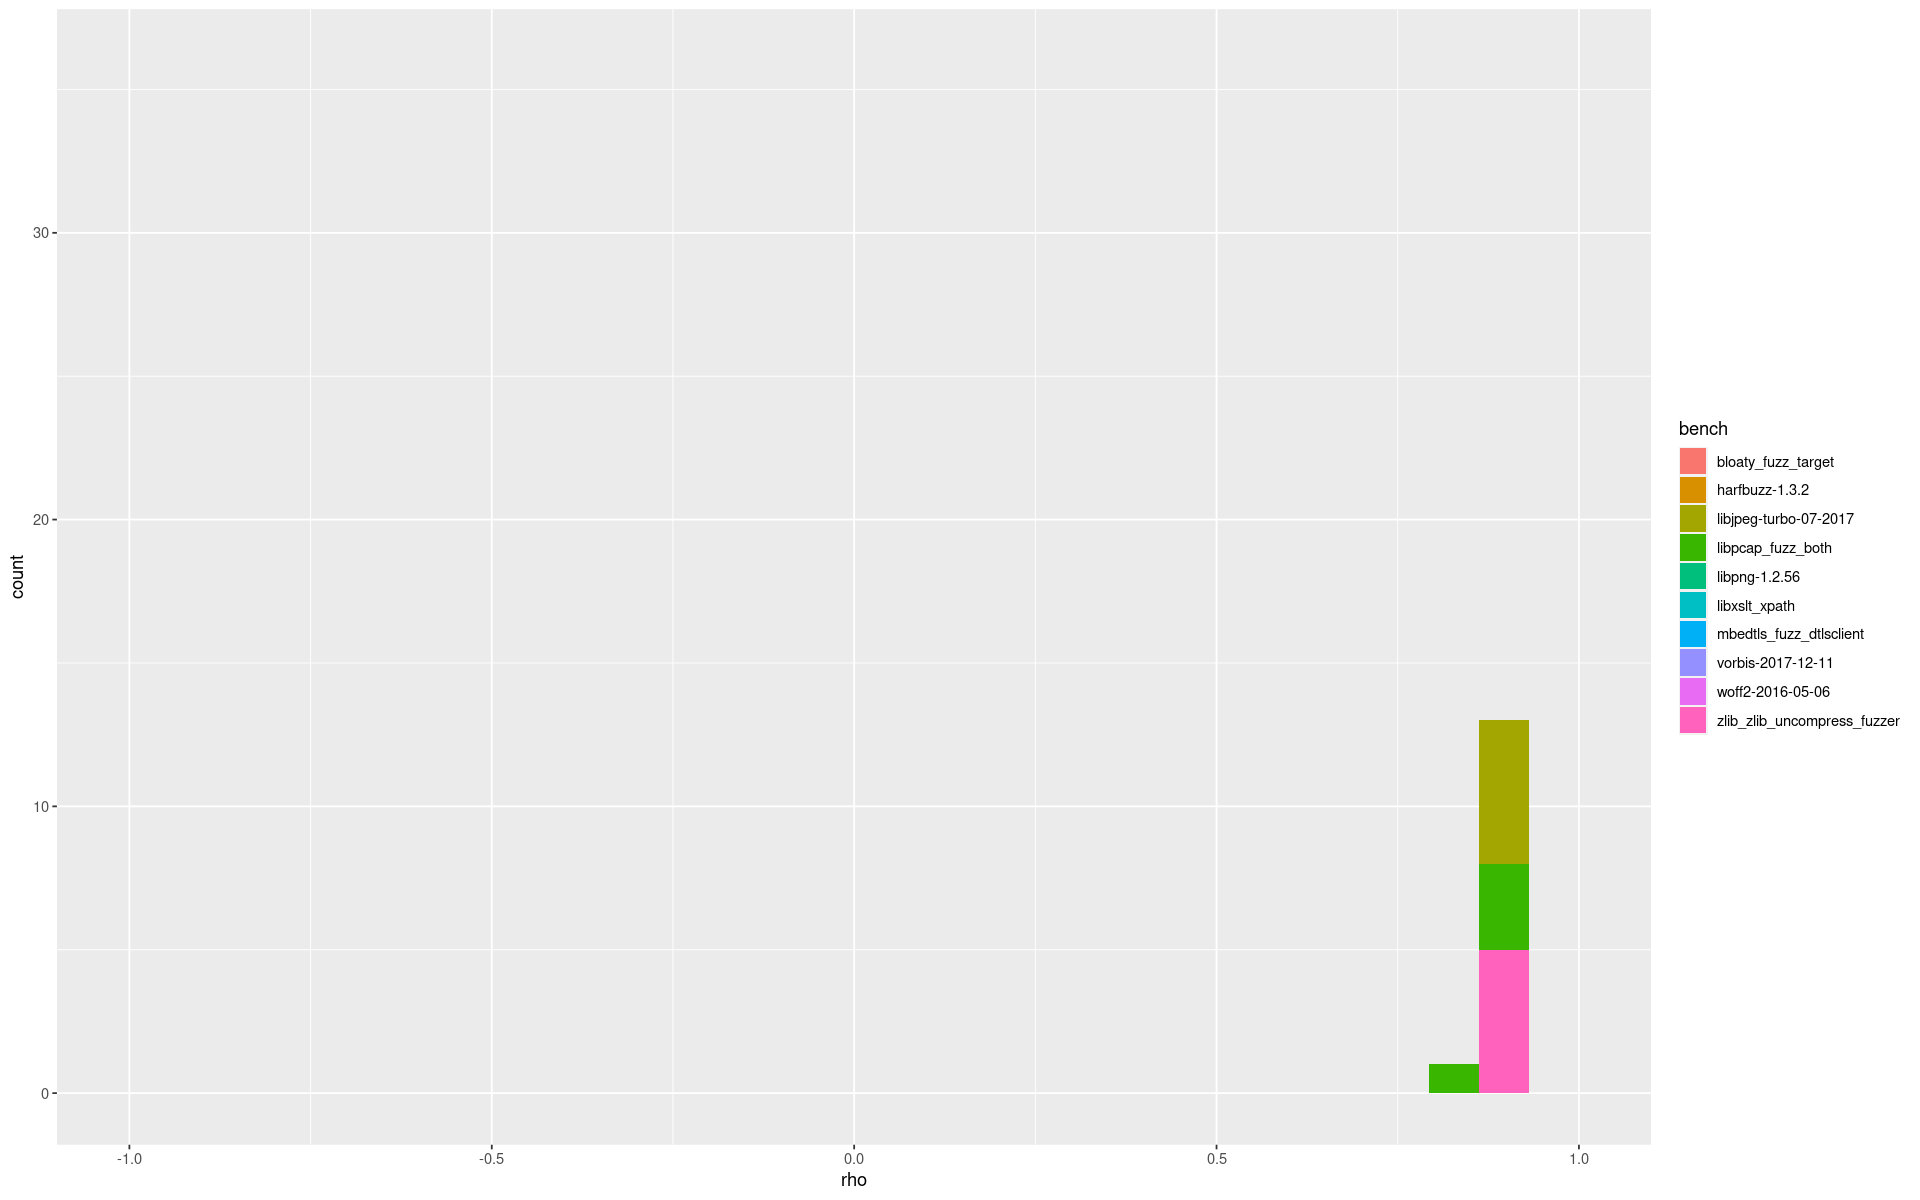

Warning message:
“Removed 10 rows containing missing values (geom_bar).”


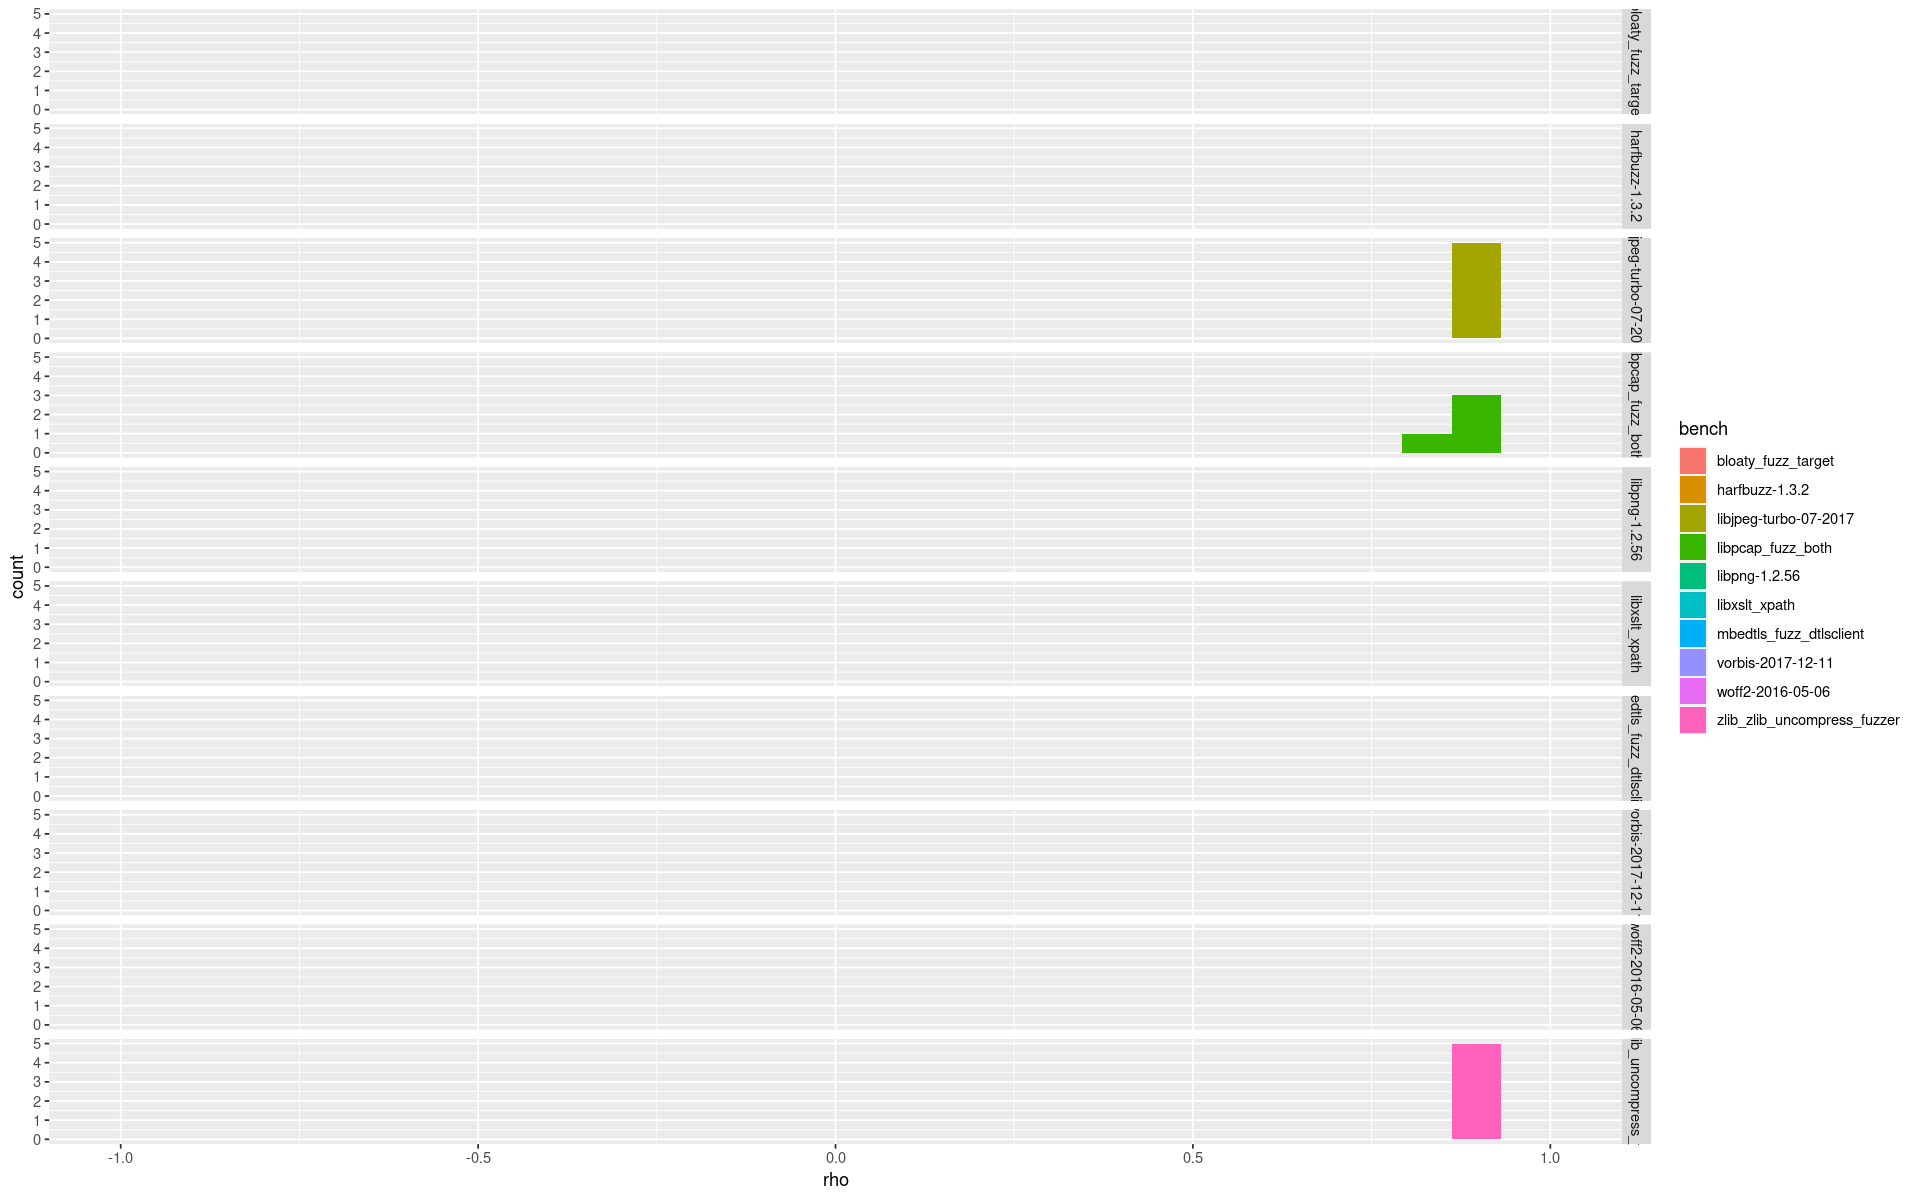

Warning message:
“Removed 10 rows containing missing values (geom_bar).”


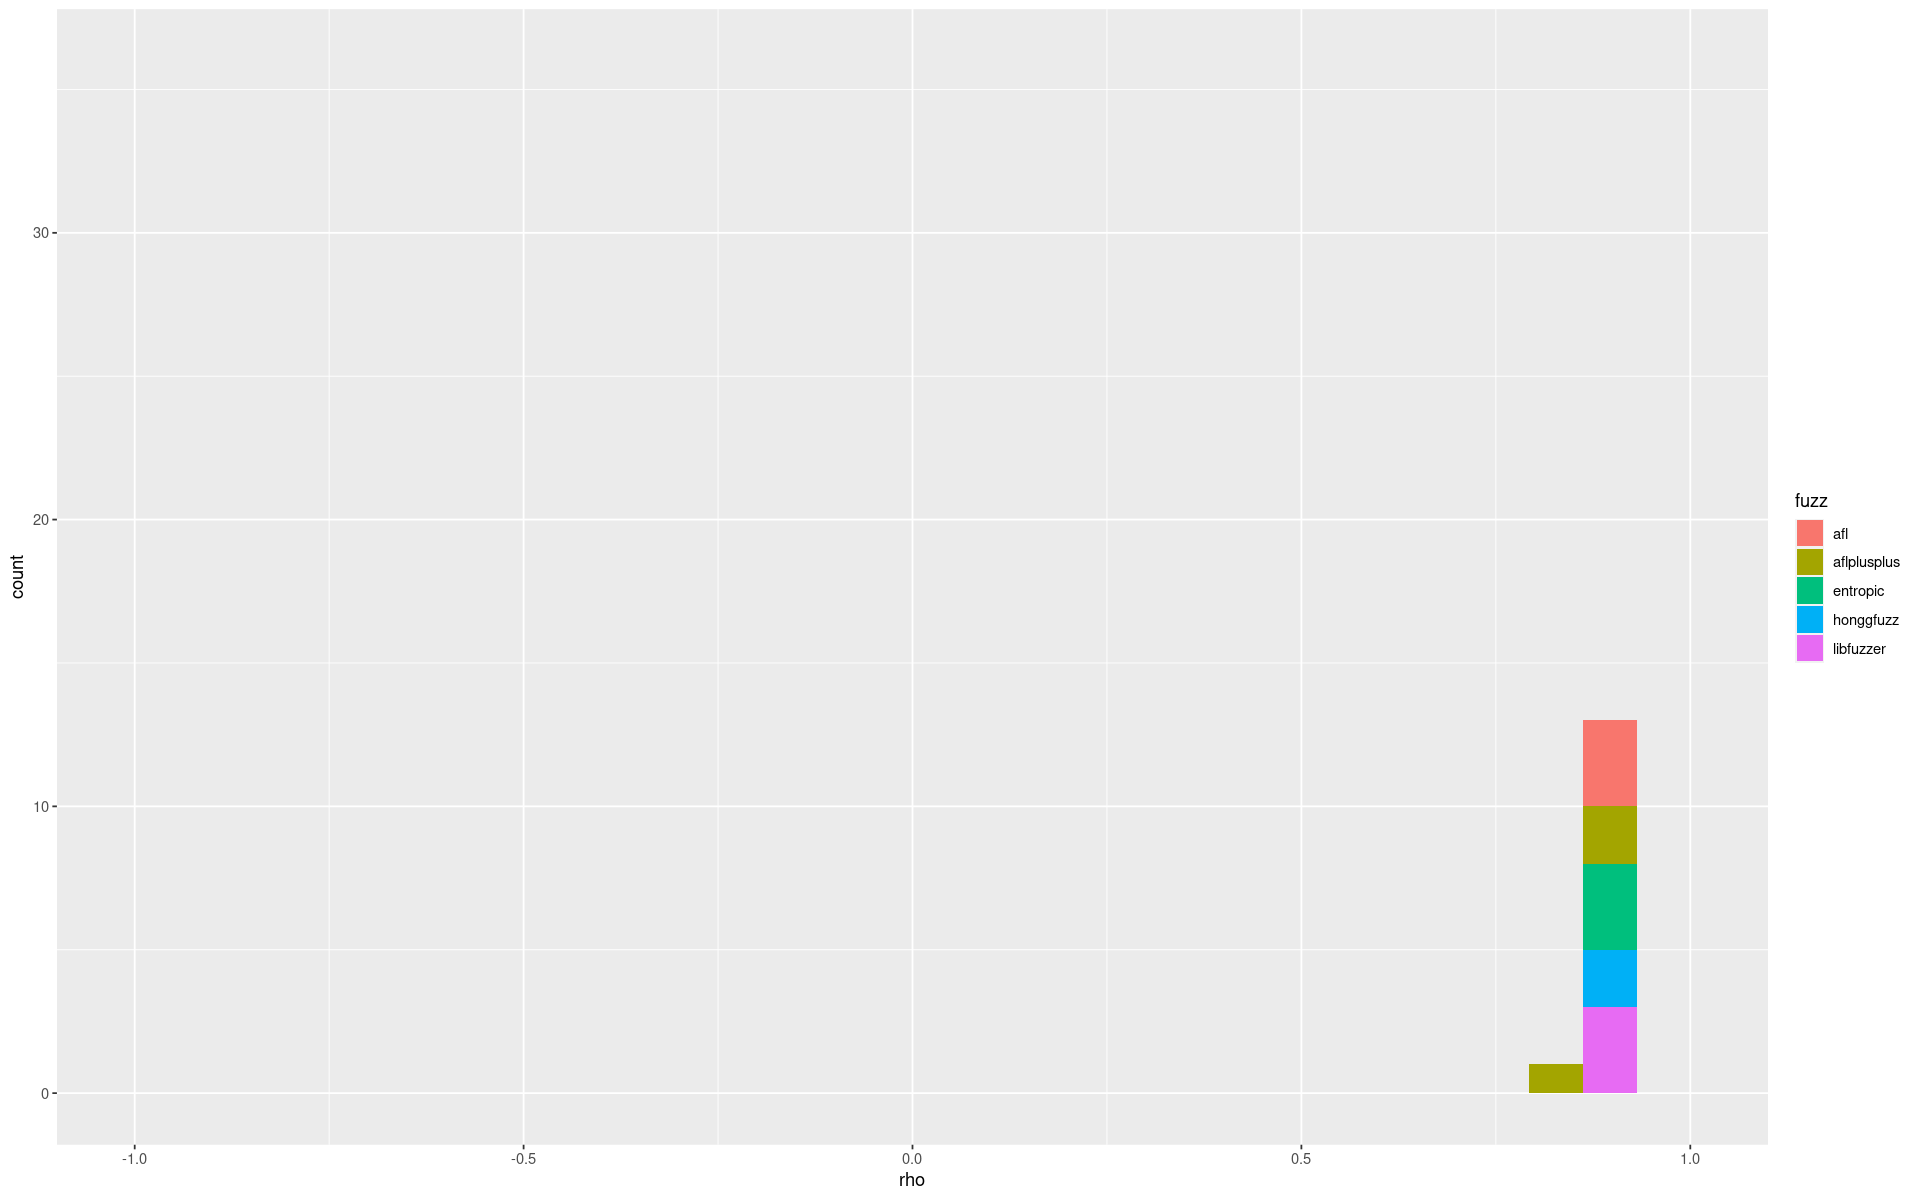

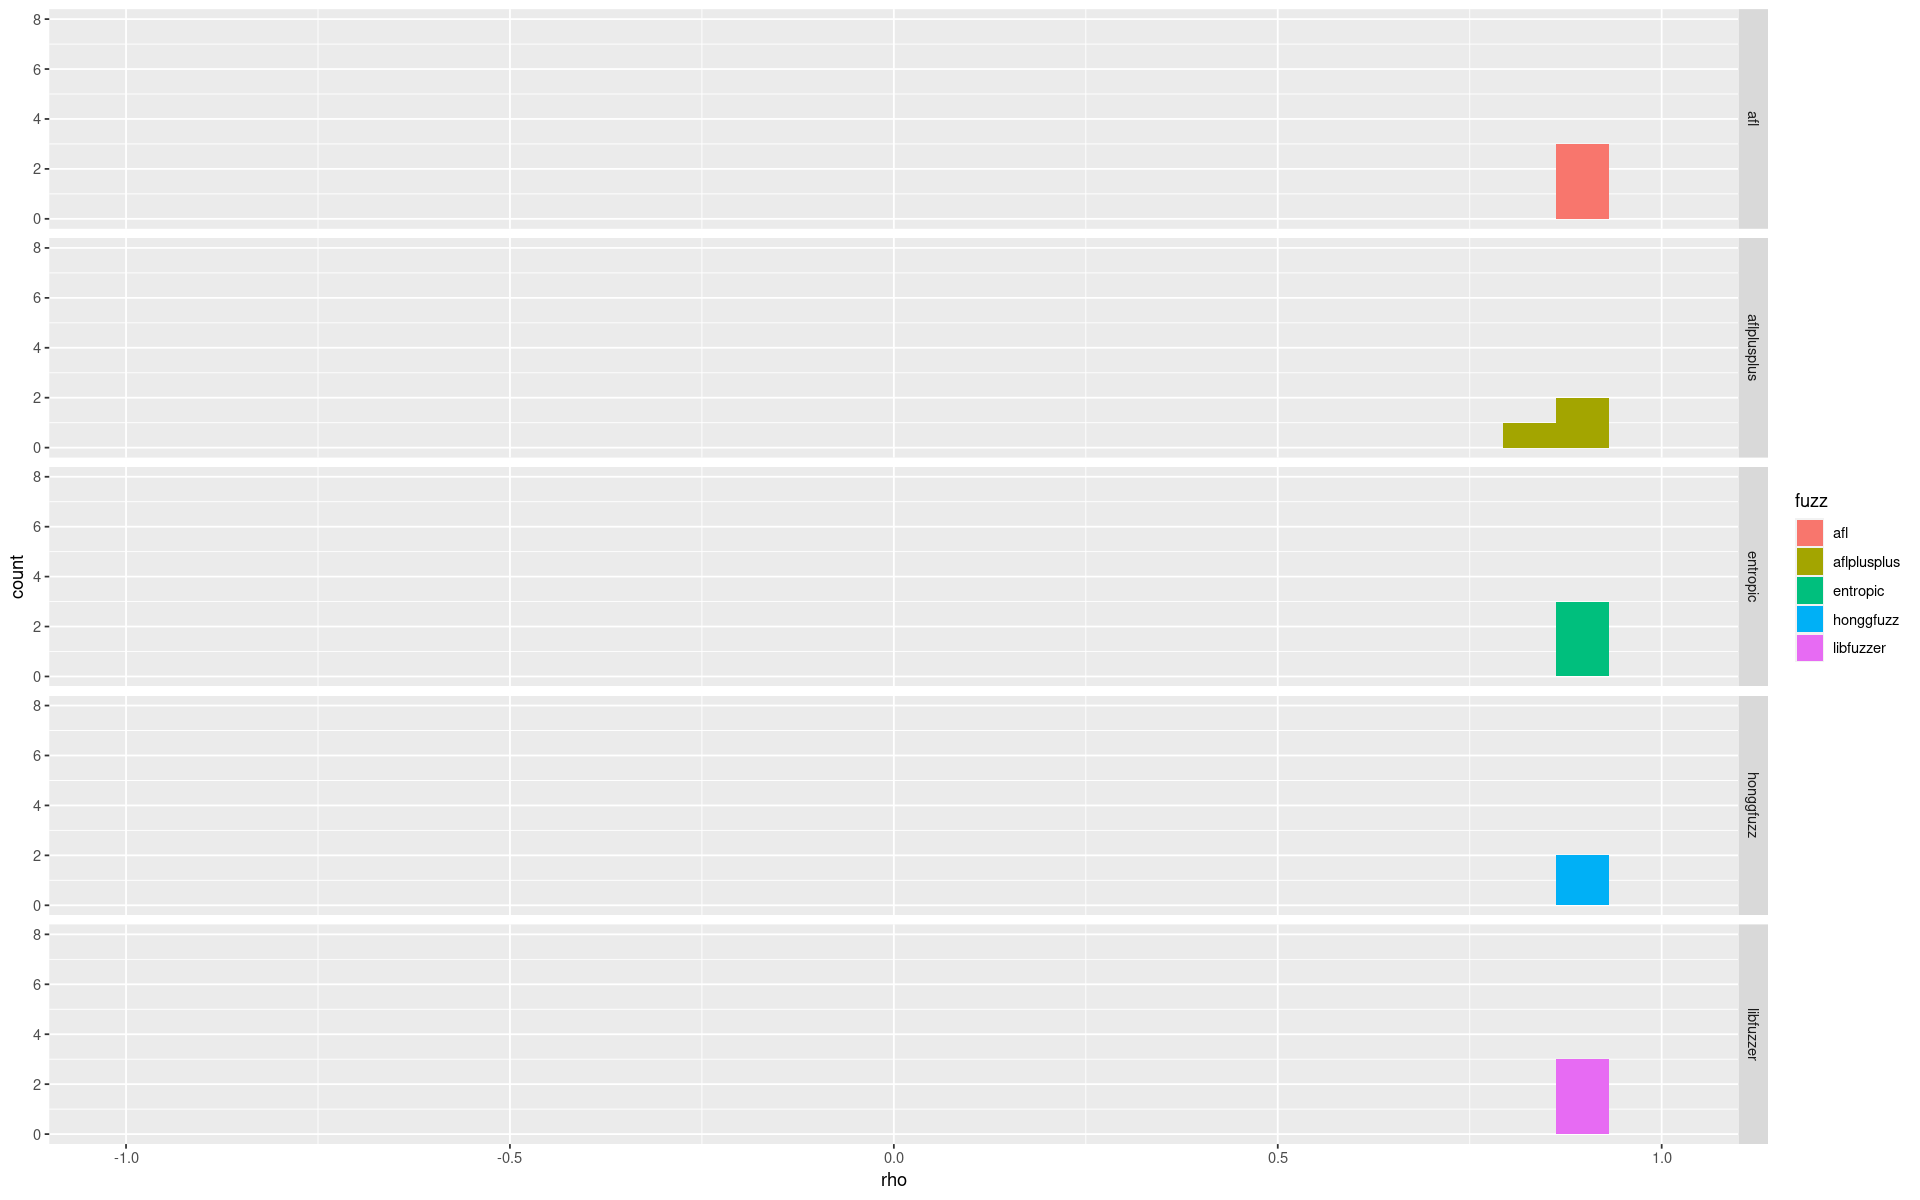

In [56]:
ggp <- ggplot(res, aes(rho, fill = bench)) + geom_histogram(bins=30)
ggp + xlim(-1, 1)
ggp + facet_grid(bench ~ .) + xlim(-1, 1)
ggp2 <- ggplot(res, aes(rho, fill = fuzz)) + geom_histogram(bins=30)
ggp2 + xlim(-1, 1)
ggp2 + facet_grid(fuzz ~ .) + xlim(-1, 1)

# Mixed Effects Model

In [ ]:
library(lme4)

model <- glmer(formula = sqrt(coverage_inc) ~ benchmark + fuzzer + (1 | mean_size_bytes) +
              (1 | initial_coverage) + fuzzer*benchmark +
              (1 | mean_exec_ns), data = d)
model

In [ ]:
plot(model)
qqnorm(resid(model))
qqline(resid(model))

In [ ]:
plot(model,
     sqrt(abs(resid(.)))~fitted(.),
     type=c("p","smooth"), col.line=1)

# Lasso Regression

In [ ]:
# install.packages("glmnet")
require("glmnet")

f <- as.formula(y ~ .*.)
y <- scaled_d$coverage_inc
# Second step: using model.matrix to take advantage of f


vars <- scaled_d[ , ! names(scaled_d) %in% c("coverage_inc", "edges_covered")]
x <- model.matrix(f, vars)[, -1]
dim(x)
cvfit <- cv.glmnet(x, y)
fit <- glmnet(x, y, lamdba=cvfit$lambda.min)
plot(fit)
coef(fit)

# Linear Regression

In [5]:
library(lme4)

model <- glm(formula = log(coverage_inc) ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns)^2, data = d, family = "poisson")
model

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.781139”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.456770”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.089243”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.955827”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.106606”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.265301”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.771441”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.934474”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.174387”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.860664”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.393878”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.410175”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.767343”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 8.011687”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.054439”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.877736”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.411646”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.220356”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.097549”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.295056”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.639876”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.926926”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.891626”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.269096”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.616771”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.595120”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.751905”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.736572”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.918695”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.131226”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.811141”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.983936”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.068904”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.214936”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.062595”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.840642”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.845024”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.450470”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.927558”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.570883”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.598422”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.075174”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.662960”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.867534”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.428105”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.215240”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.247024”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.704414”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.940171”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 8.002025”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.940171”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.846439”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.752765”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.280396”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.283448”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.953243”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.280008”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.086775”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.499810”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.723832”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.543295”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.274762”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.480428”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.526495”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.066467”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.683864”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.677083”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.890349”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.749393”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.605170”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.695758”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 8.037866”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.137727”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.749931”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.605170”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.491088”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.921578”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.164786”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.989560”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.028279”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.258412”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.808142”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 8.118505”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.996452”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.641907”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.805135”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.159055”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.459904”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.913155”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.513230”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.976348”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.732808”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.620401”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.564348”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.752573”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.476464”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.727432”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.641564”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.866933”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.773080”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.332719”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.388946”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.655440”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.905275”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.623642”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.569481”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.303170”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.052089”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.880048”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.120297”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.505332”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.659482”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.252273”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.625595”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.789869”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.955837”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.227662”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.406711”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.766192”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.682131”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.192362”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.075174”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.968850”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 8.427487”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.673298”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.964136”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.253829”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.984463”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.411646”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.369448”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.

Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.577634”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.863631”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.950815”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.444131”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.957527”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.274762”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 5.758902”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.493754”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 4.465908”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.133398”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 7.606885”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.253829”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.070738”
Warning message in dpois(y, mu, log = TRUE):
“non-integer x = 6.


Call:  glm(formula = log(coverage_inc) ~ (benchmark + fuzzer + initial_coverage + 
    mean_size_bytes + mean_exec_ns)^2, family = "poisson", data = d)

Coefficients:
                                           (Intercept)  
                                             2.220e+00  
                               benchmarkharfbuzz-1.3.2  
                                            -7.343e-02  
                        benchmarklibjpeg-turbo-07-2017  
                                            -4.062e-01  
                            benchmarklibpcap_fuzz_both  
                                            -1.882e-01  
                                benchmarklibpng-1.2.56  
                                            -4.212e-01  
                                benchmarklibxslt_xpath  
                                             2.940e-02  
                      benchmarkmbedtls_fuzz_dtlsclient  
                                            -2.769e-01  
                            benchm

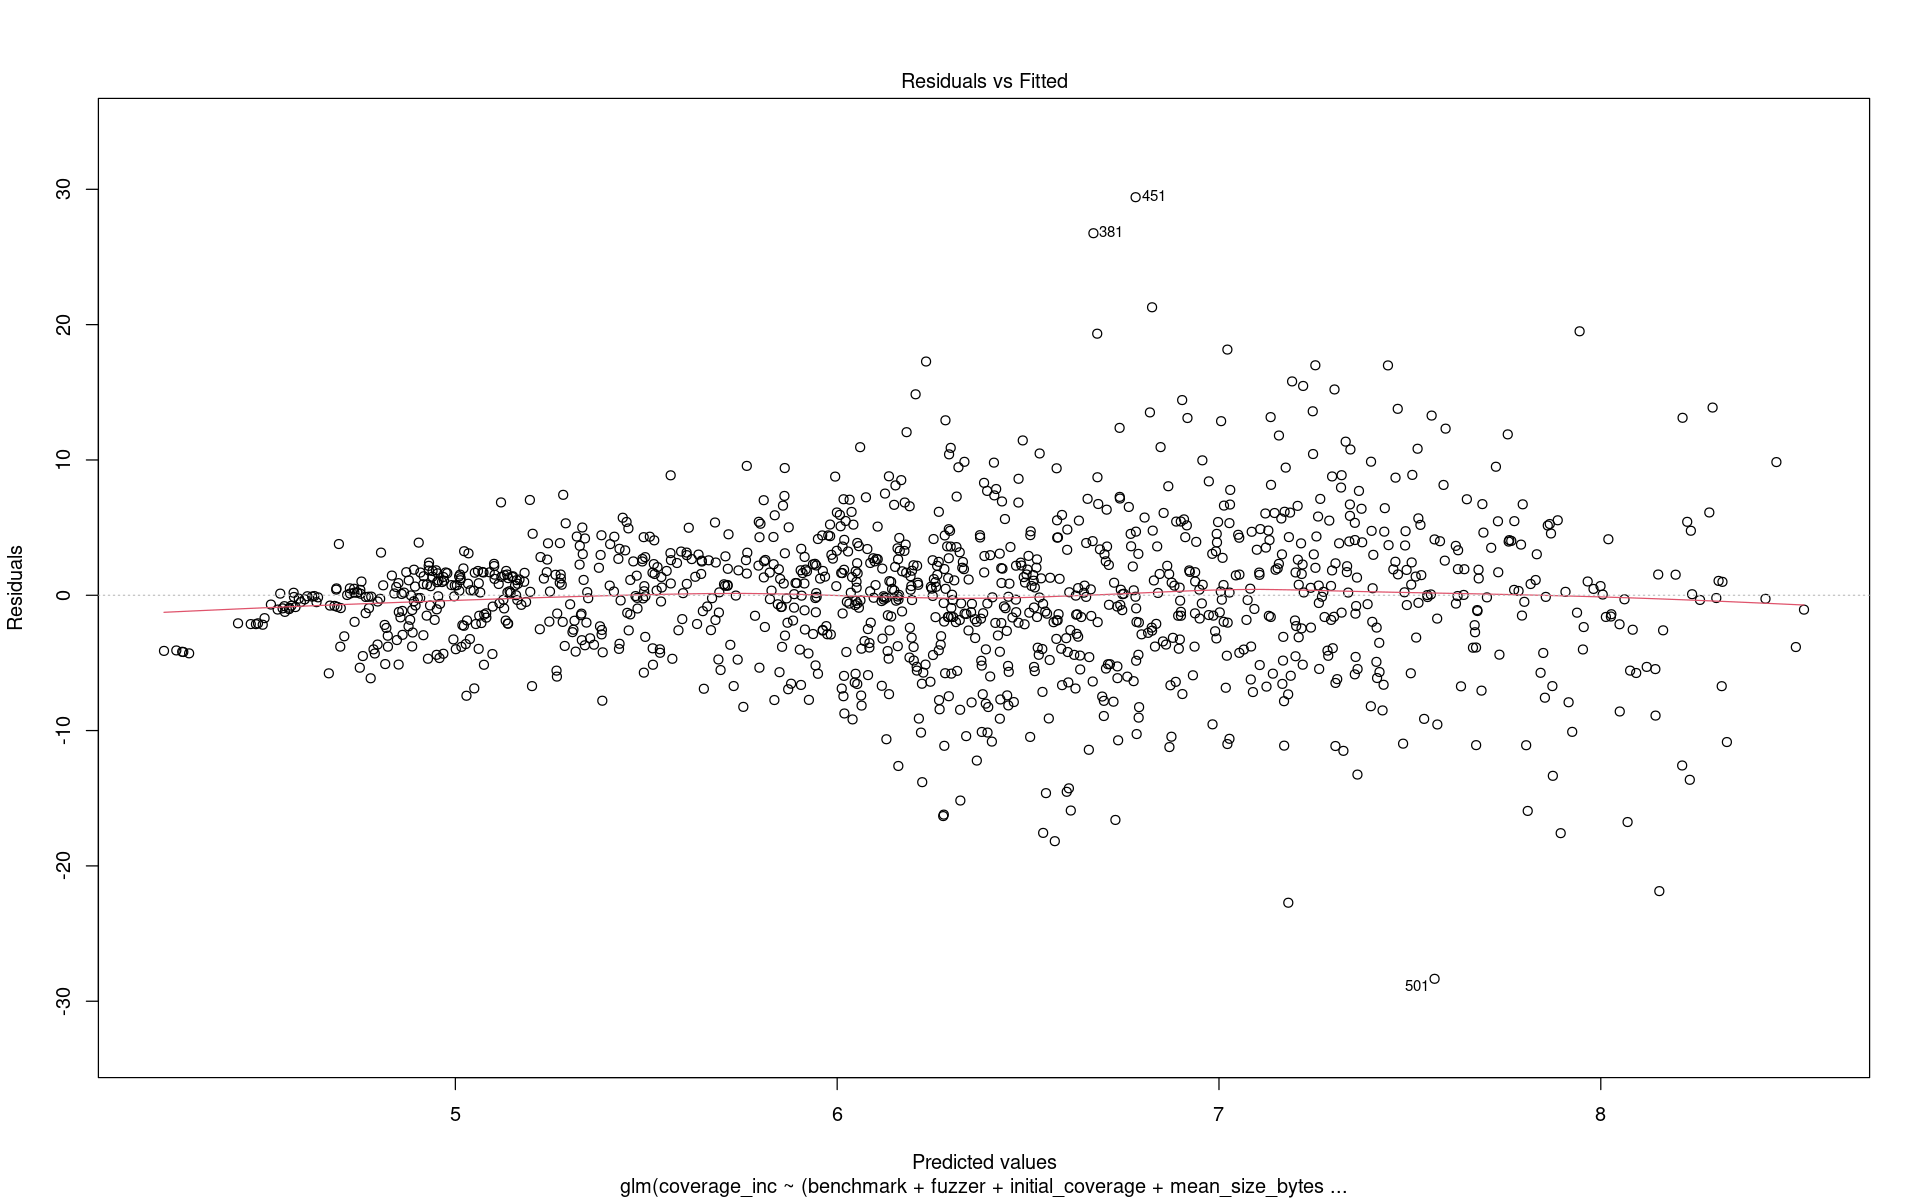

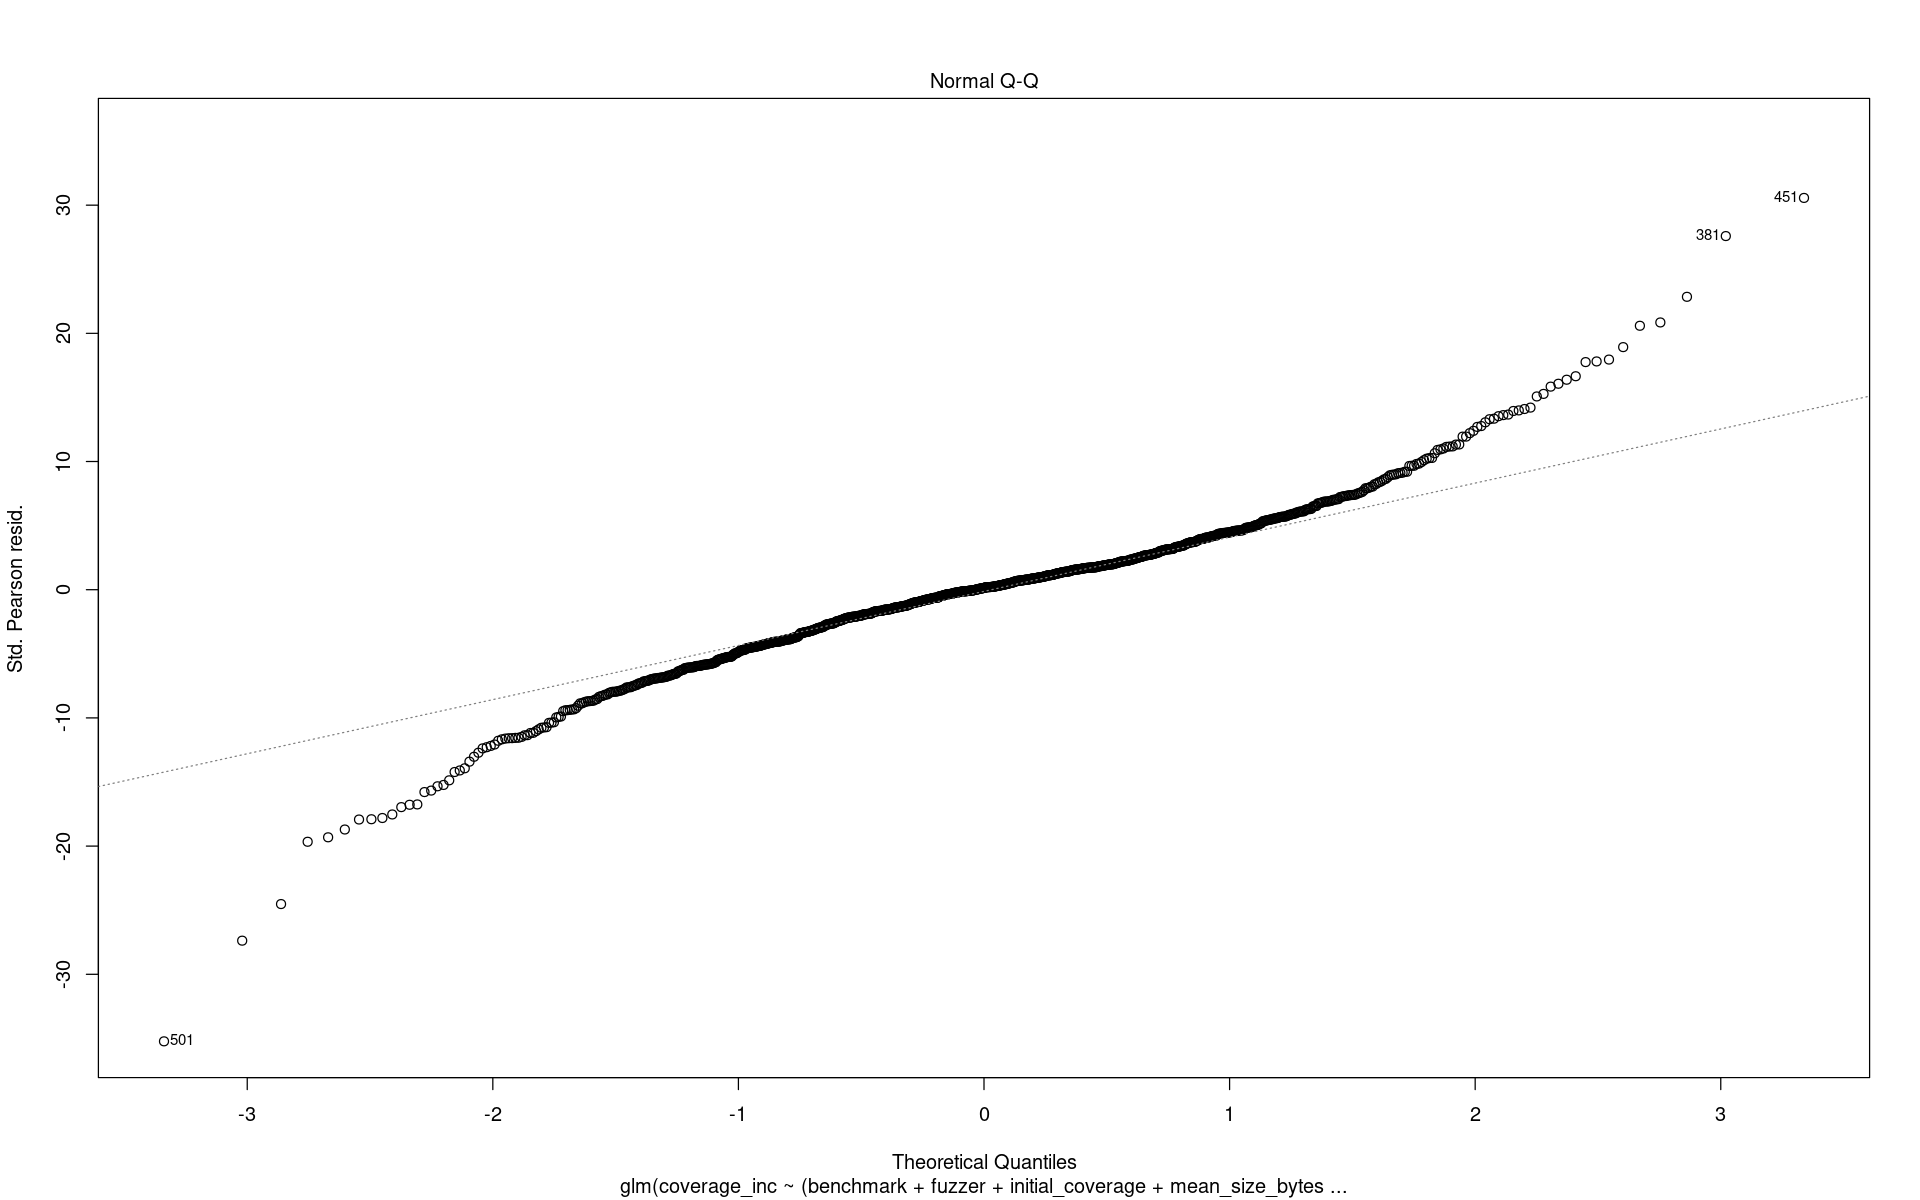

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


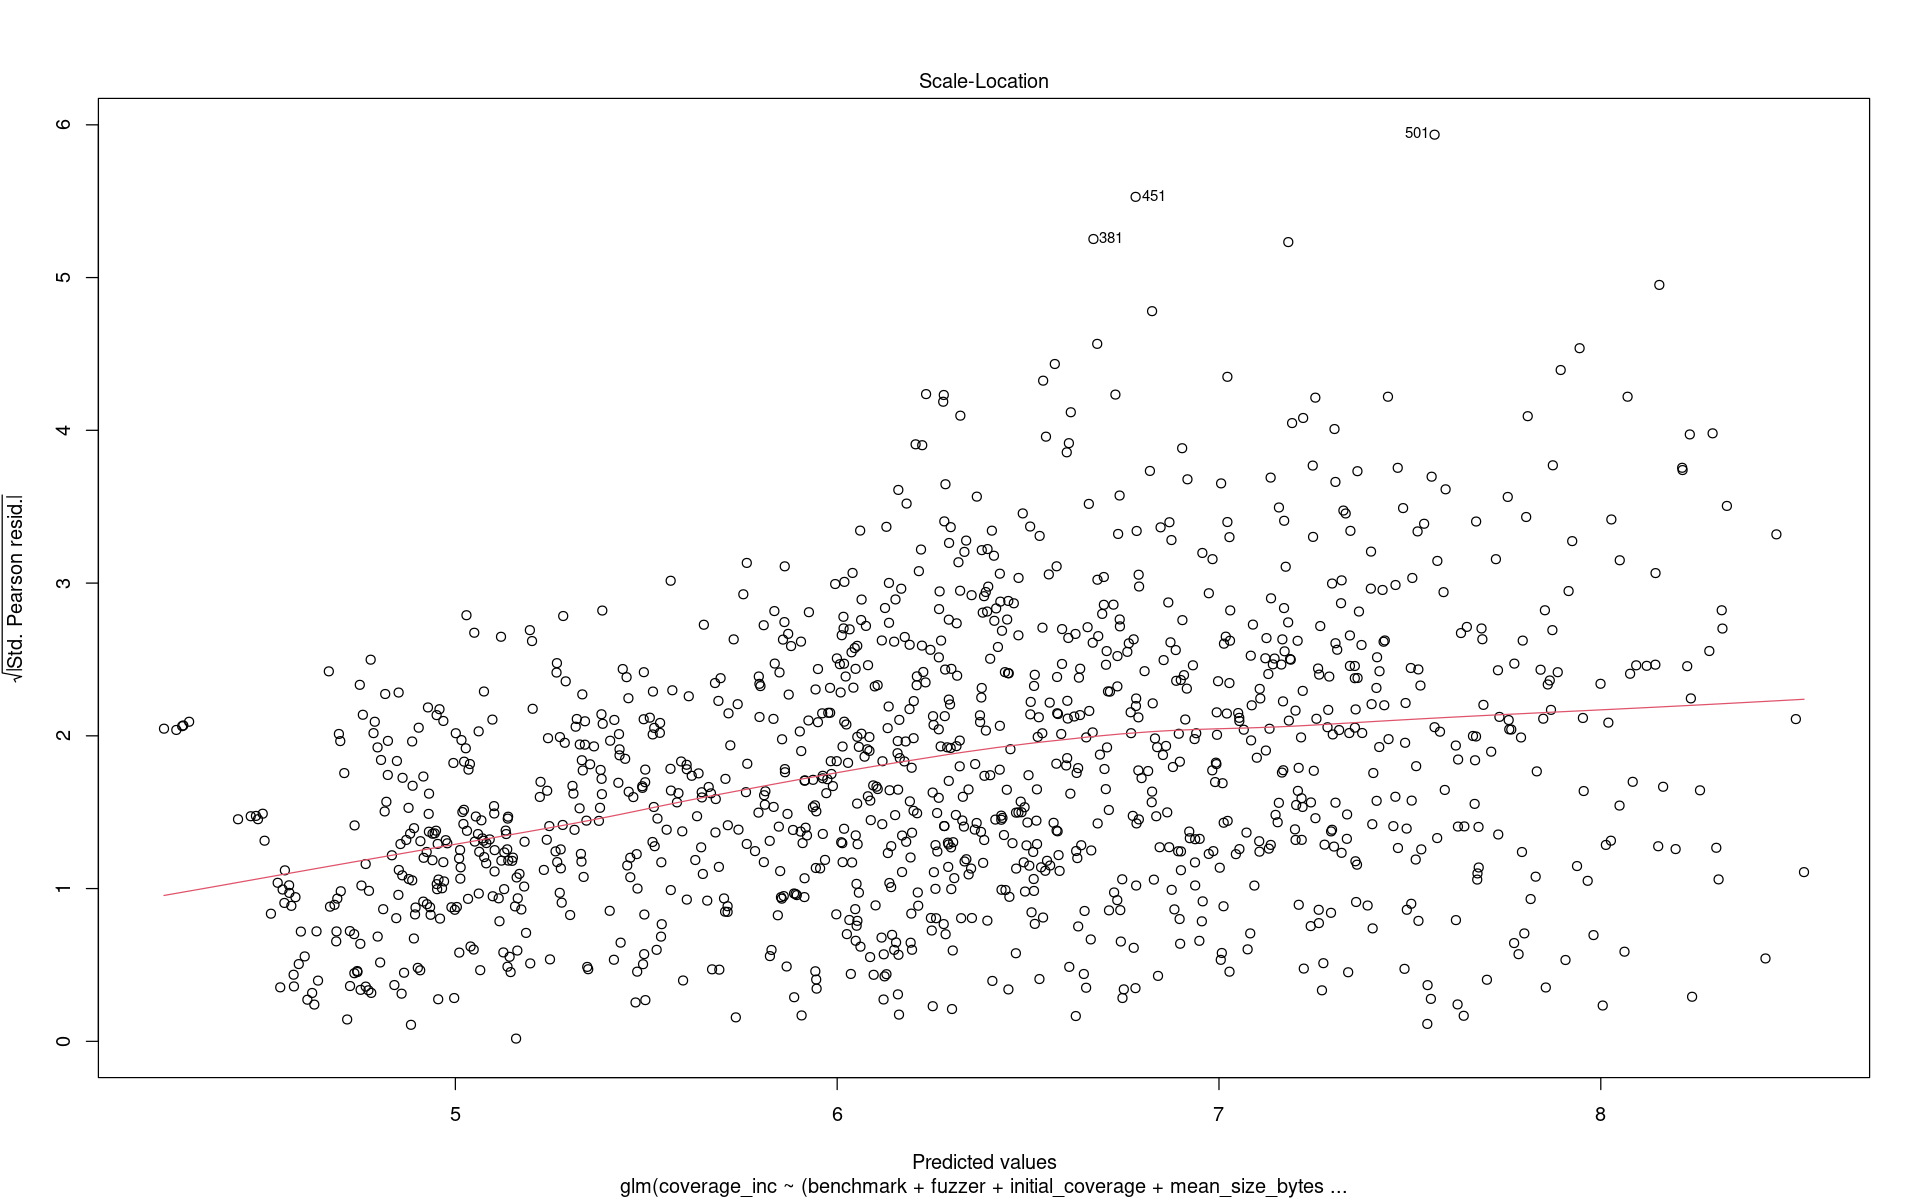

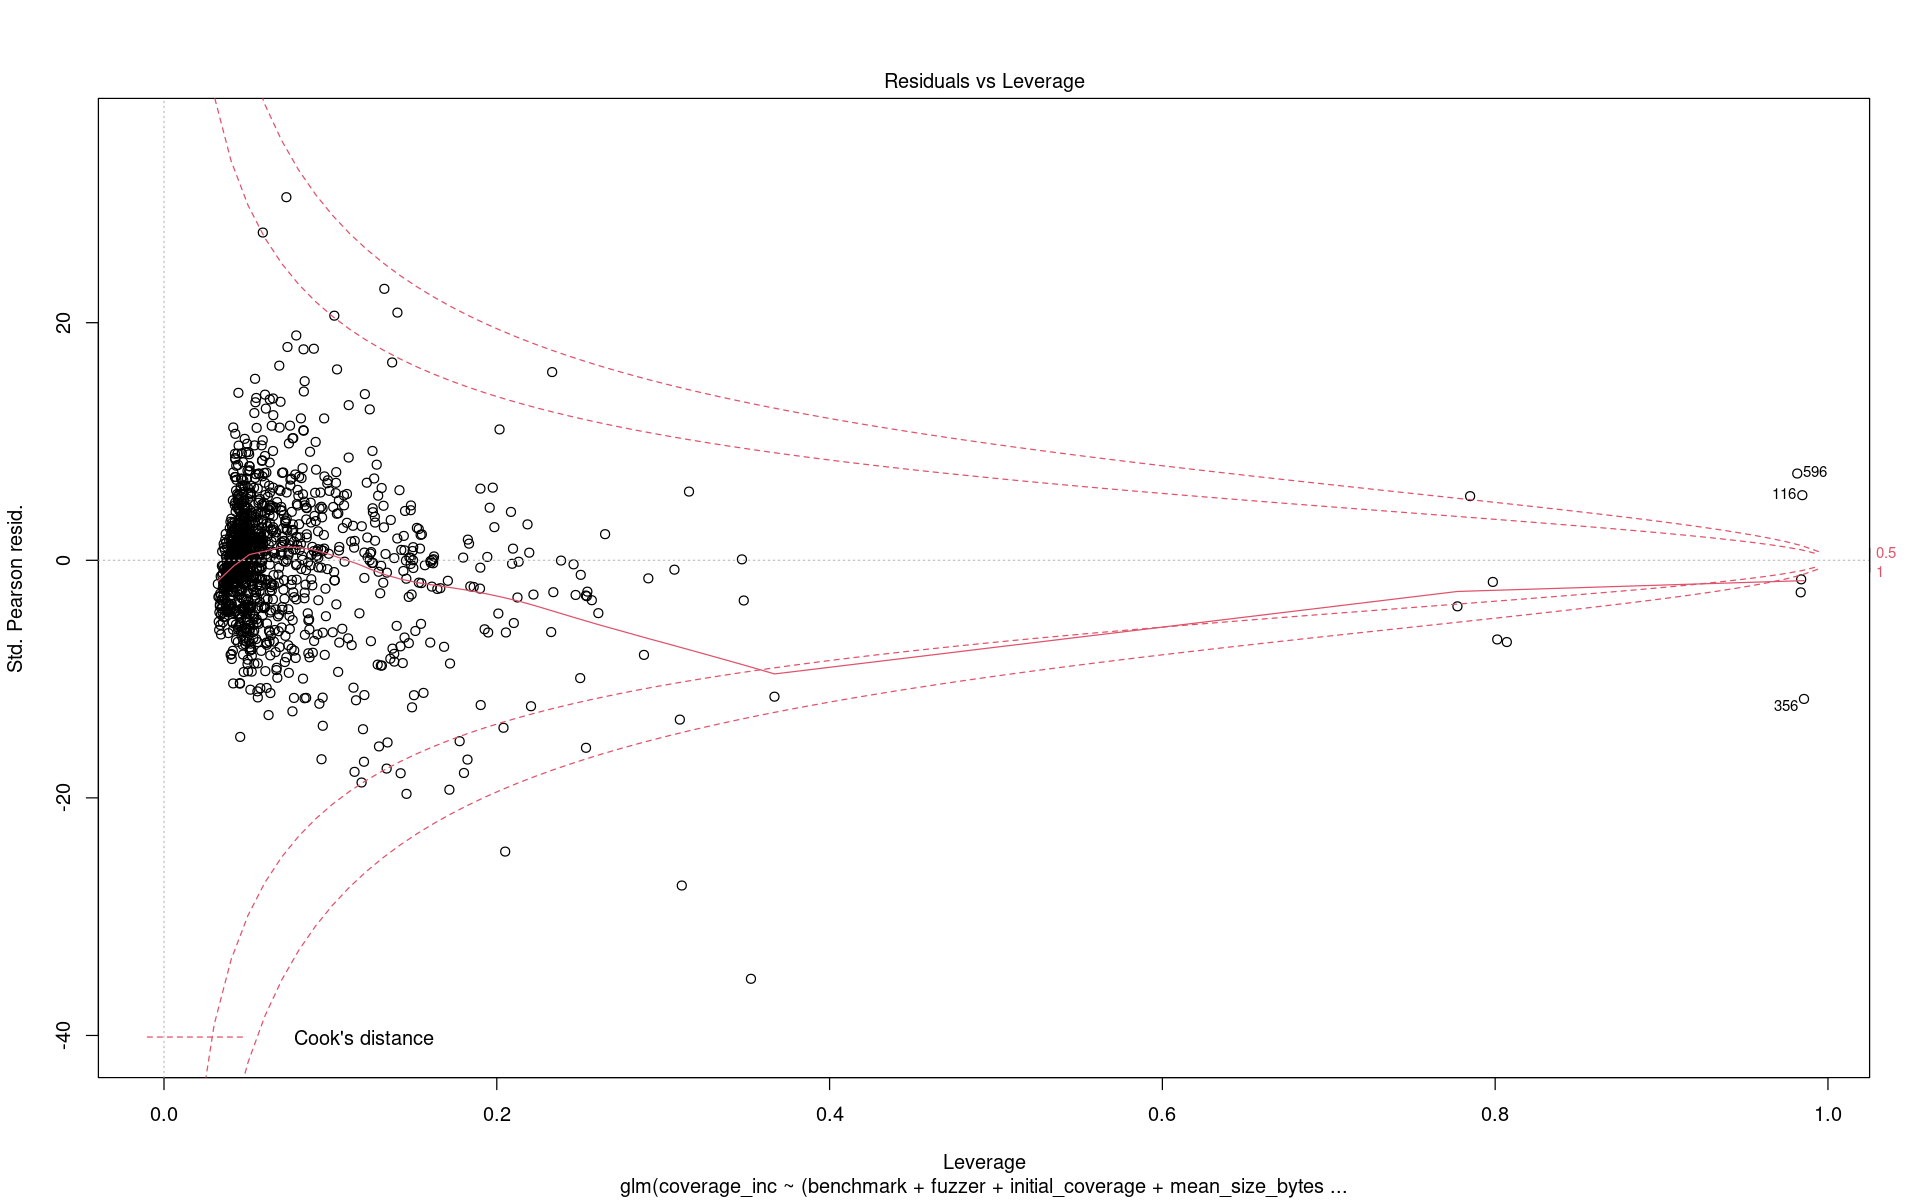

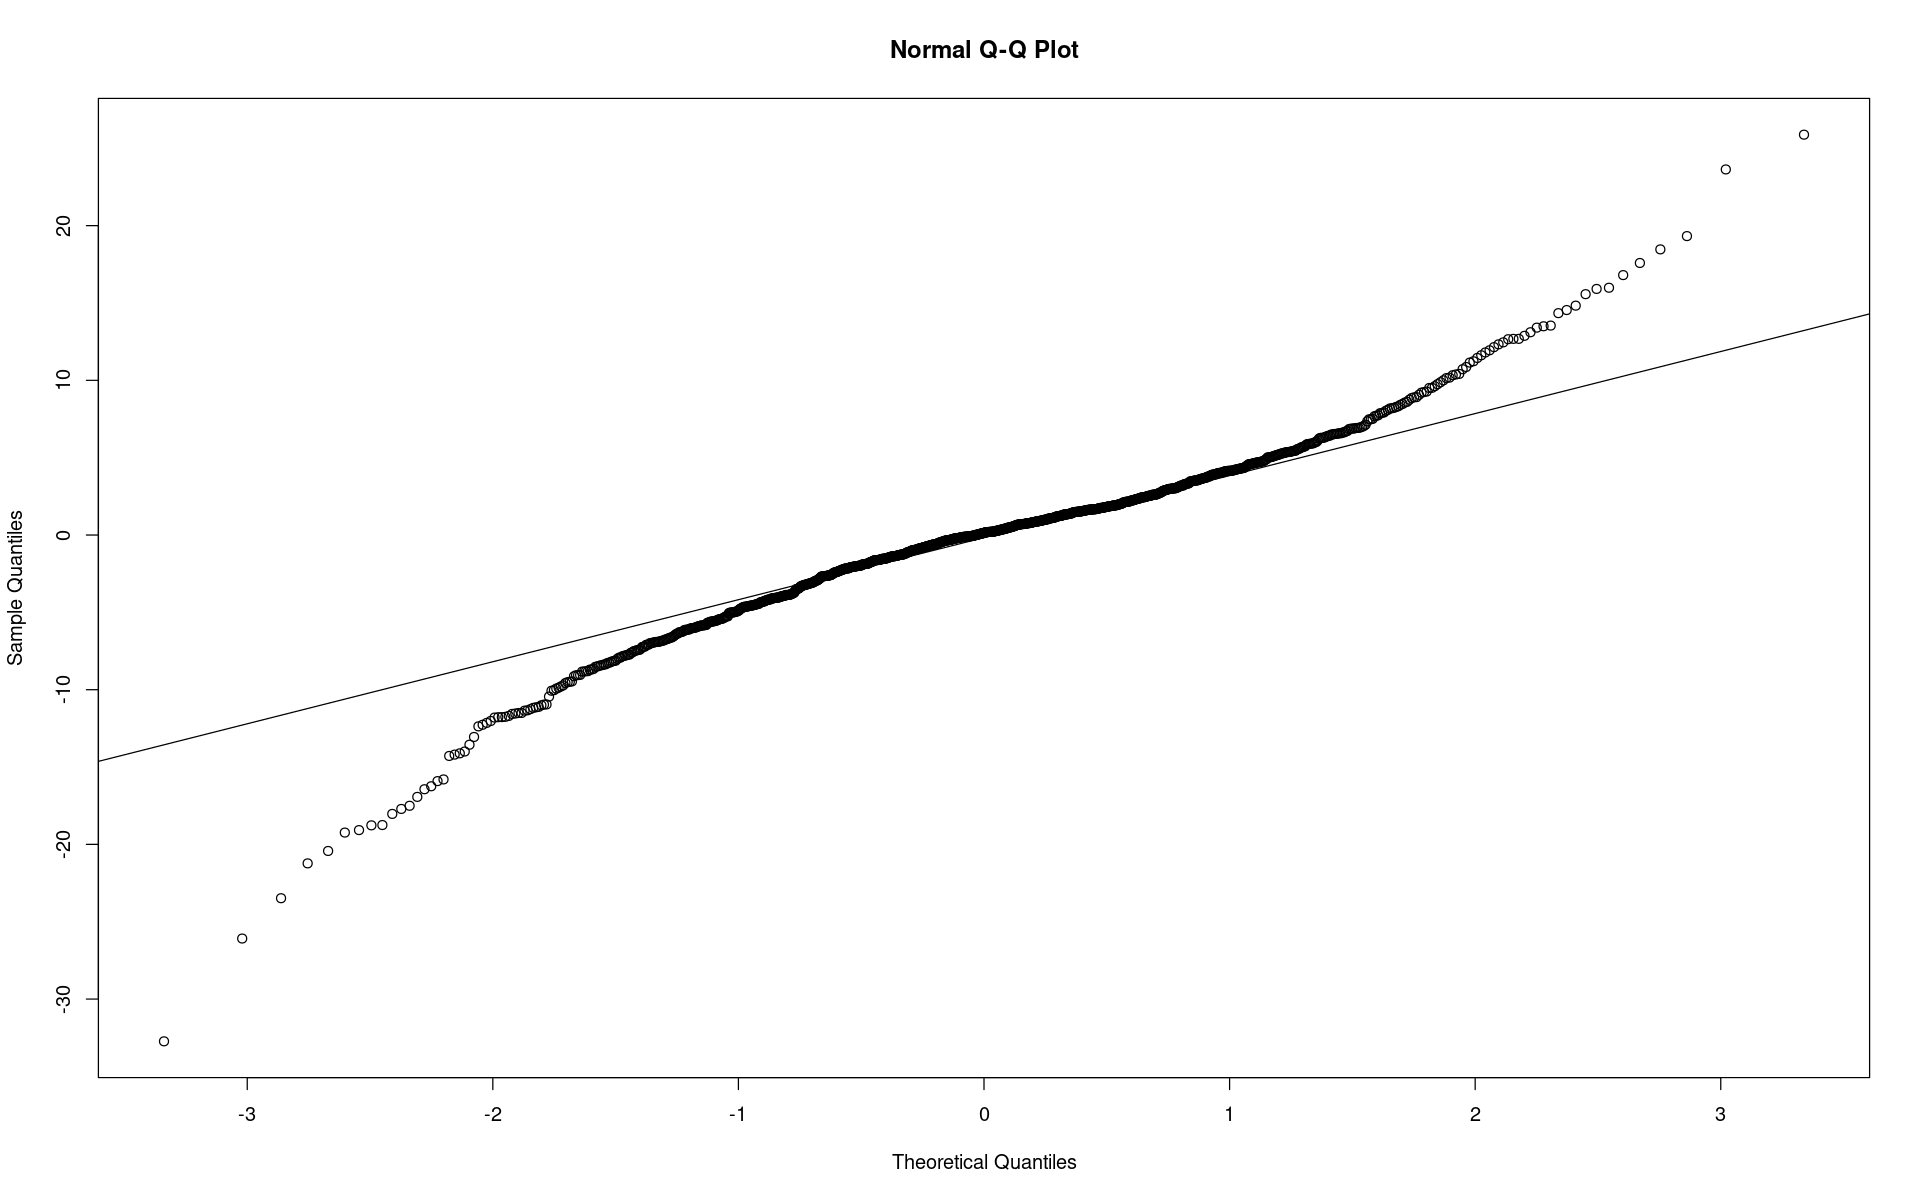

In [128]:
plot(model)
qqnorm(resid(model))
qqline(resid(model))


In [132]:
set.seed(334) # Set Seed so that same sample can be reproduced in future also
# Now Selecting 75% of data as sample from total 'n' rows of the data
s <- floor(.75*nrow(d))
sample <- sample.int(n = nrow(d), size = s, replace = FALSE)
train <- d[sample, ]
test  <- d[-sample, ]

model <- glm(formula = coverage_inc ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = train)

preds <- predict(model, test)
loss <- data.frame(abs(preds - test$coverage_inc))
colMeans(loss, na.rm = TRUE)


abs.preds...test.coverage_inc. 
                      122.9732

abs.invBoxCox.preds..lambda....test.coverage_inc. 
                                         118.1003

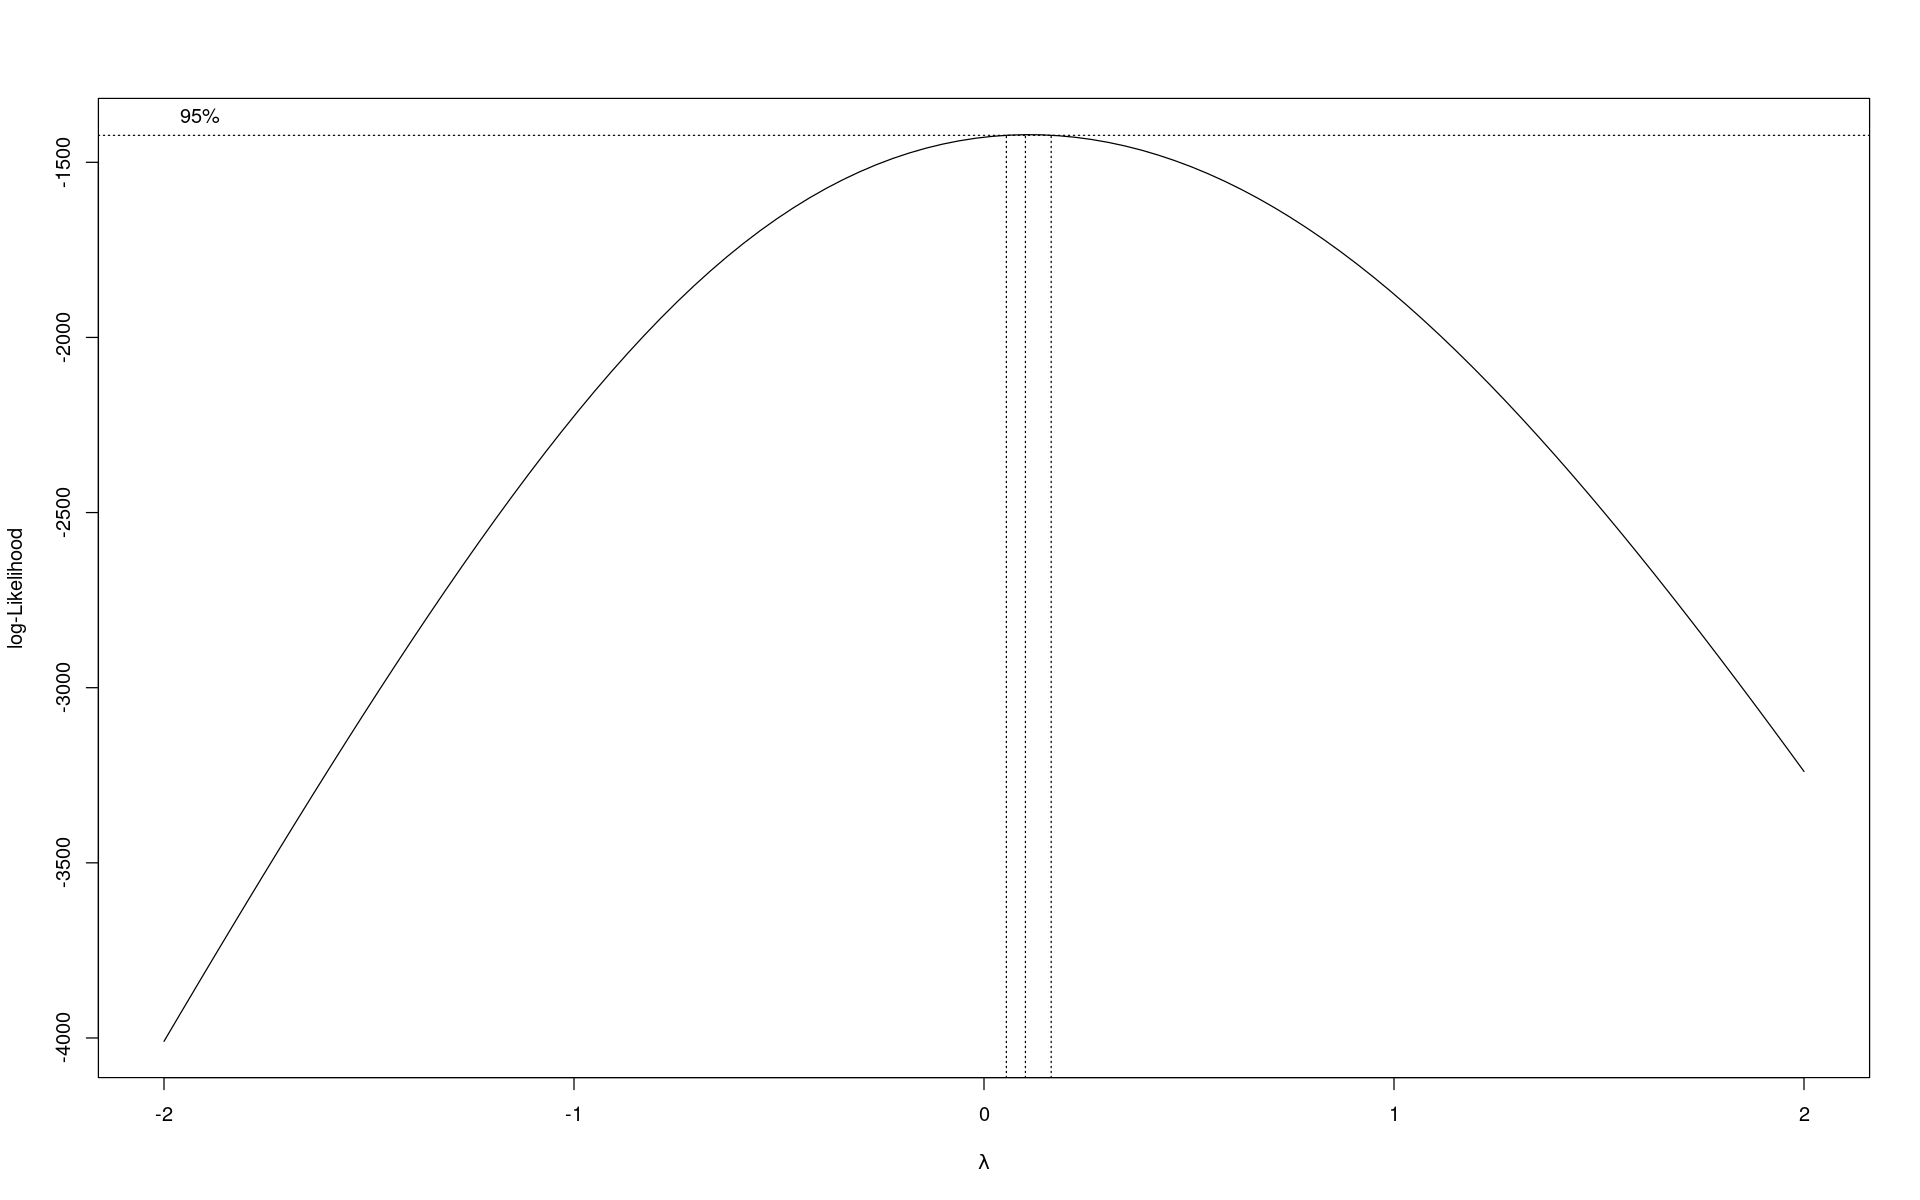

In [147]:
require(MASS)

set.seed(9374) # Set Seed so that same sample can be reproduced in future also
# Now Selecting 75% of data as sample from total 'n' rows of the data
s <- floor(.75*nrow(d))
sample <- sample.int(n = nrow(d), size = s, replace = FALSE)
train <- d[sample, ]
test  <- d[-sample, ]

bc <- boxcox(train$coverage_inc ~ (train$benchmark + train$fuzzer +
              train$initial_coverage + train$mean_size_bytes + 
              train$mean_exec_ns + train$corpus_size)^2)
lambda <- bc$x[which.max(bc$y)]

model <- glm(formula = ((coverage_inc^lambda-1)/lambda) ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = train)

preds <- predict(model, test)
invBoxCox <- function(x, lambda)
    if (lambda == 0) exp(x) else (lambda*x + 1)^(1/lambda)
        
loss <- data.frame(abs(invBoxCox(preds, lambda) - test$coverage_inc))
colMeans(loss, na.rm = TRUE)



In [32]:
set.seed(334) # Set Seed so that same sample can be reproduced in future also

partition = "harfbuzz-1.3.2"
train <- d_statics %>% filter(benchmark != partition)
test  <- d_statics %>% filter(benchmark == partition)

model <- glm(formula = coverage_inc ~ (fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = train)

preds <- predict(model, test)
loss <- data.frame(abs(preds - test$coverage_inc))
colMeans(loss, na.rm = TRUE)


abs.preds...test.coverage_inc. 
                      1159.241

In [65]:
install.packages("caret", dependencies = TRUE)

library(caret)

#specify the cross-validation method
ctrl <- trainControl(method = "cv", number = 5)

#fit a regression model and use k-fold CV to evaluate performance
model <- train(log(coverage_inc) ~ (benchmark + fuzzer +
              initial_coverage + mean_size_bytes + 
              mean_exec_ns + corpus_size)^2, data = d, method = "glm", trControl = ctrl)

#view summary of k-fold CV               
print(model)


Installing package into ‘/home/wolffd/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

Warning message:
“dependency ‘randomForest’ is not available”

Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster


The following object is masked from ‘package:purrr’:

    lift


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“predicti

Generalized Linear Model 

1064 samples
   6 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 850, 851, 852, 851, 852 
Resampling results:

  RMSE       Rsquared   MAE      
  0.1929091  0.9643883  0.1302255



# POLR on Fuzzer rank

In [82]:
library(MASS)

model <- polr(formula = per_trial_ranks ~ benchmark + fuzzer + initial_coverage + corpus_size +
    mean_size_bytes + mean_exec_ns + ineq_unexplored + eq_unexplored + indir_reached + fuzzer*benchmark +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer, data = scaled_d)

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in polr(formula = per_trial_ranks ~ benchmark + fuzzer + initial_coverage + :
“design appears to be rank-deficient, so dropping some coefs”

Re-fitting to get Hessian




ERROR: Error in polr(formula = per_trial_ranks ~ benchmark + fuzzer + initial_coverage + : 'start' is not of the correct length


In [80]:
library(rms)

orm(formula = per_trial_ranks ~ benchmark + fuzzer + initial_coverage + corpus_size +
    mean_size_bytes + mean_exec_ns + ineq_unexplored + eq_unexplored + indir_reached + fuzzer*benchmark +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer + ineq_unexplored*fuzzer, data = scaled_d)

Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”
Warning message in .local(x, ...):
“singularity problem”


Frequencies of Missing Values Due to Each Variable
 per_trial_ranks        benchmark           fuzzer initial_coverage 
             125                0                0                0 
     corpus_size  mean_size_bytes     mean_exec_ns  ineq_unexplored 
               0                0                0                0 
   eq_unexplored    indir_reached 
               0                0 

Logistic (Proportional Odds) Ordinal Regression Model
 
 orm(formula = per_trial_ranks ~ benchmark + fuzzer + initial_coverage + 
     corpus_size + mean_size_bytes + mean_exec_ns + ineq_unexplored + 
     eq_unexplored + indir_reached + fuzzer * benchmark + initial_coverage * 
     fuzzer + mean_size_bytes * fuzzer + mean_exec_ns * fuzzer + 
     ineq_unexplored * fuzzer, data = scaled_d)
 
 
 Frequencies of Responses
 
   1   2   3   4   5 
 231 221 203 207 202 
 
 
                         Model Likelihood               Discrimination    Rank Discrim.    
                               Ratio 

# Bootstrapped Regression

In [86]:
require(car)

m <- lm(formula = coverage_inc ~ benchmark + fuzzer + initial_coverage + corpus_size +
    mean_size_bytes + mean_exec_ns + ineq_unexplored + eq_unexplored + indir_reached + fuzzer*benchmark +
    initial_coverage*fuzzer + mean_size_bytes*fuzzer + mean_exec_ns*fuzzer + ineq_unexplored*fuzzer, data = scaled_d)
b <- Boot(m, method="resid")
summary(b)
confint(b)

,R,original,bootBias,bootSE,bootMed
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),999,1552.57664,-2.6869020,172.4592,1550.82082
benchmarkharfbuzz-1.3.2,999,1910.97322,-2.8630997,102.9440,1908.22952
benchmarklibjpeg-turbo-07-2017,999,-655.81235,-0.2562388,154.2813,-657.29847
benchmarklibpcap_fuzz_both,999,-714.76155,3.1897373,177.4180,-714.32554
benchmarklibpng-1.2.56,999,-1162.71655,1.0326271,171.5104,-1164.02789
benchmarklibxslt_xpath,999,1363.17142,-0.6650167,190.8335,1357.82518
benchmarkmbedtls_fuzz_dtlsclient,999,-684.50219,3.4665994,152.1419,-683.51943
benchmarkvorbis-2017-12-11,999,-902.41261,2.6783658,153.4591,-901.22741
benchmarkwoff2-2016-05-06,999,-1172.43825,0.7946986,149.6671,-1169.99991


Warning message in confint.boot(b):
“BCa method fails for this problem.  Using 'perc' instead”


,2.5 %,97.5 %
(Intercept),1178.6020,1884.6869
benchmarkharfbuzz-1.3.2,1704.5935,2120.8682
benchmarklibjpeg-turbo-07-2017,-946.9049,-345.6046
benchmarklibpcap_fuzz_both,-1053.2599,-315.4637
benchmarklibpng-1.2.56,-1515.8651,-813.9549
benchmarklibxslt_xpath,985.8793,1760.1520
benchmarkmbedtls_fuzz_dtlsclient,-973.0730,-371.0154
benchmarkvorbis-2017-12-11,-1180.4615,-582.7149
benchmarkwoff2-2016-05-06,-1475.1410,-854.3683
benchmarkzlib_zlib_uncompress_fuzzer,-1657.2916,-957.8528


# Preserving below this point for posterity, ignore

abs.preds...test.coverage_inc. 
                      115.7063

In [119]:
library(glmnet)

#perform k-fold cross-validation to find optimal lambda value
cv_model <- cv.glmnet(x, y, alpha = 1)

ERROR: Error in nrow(x): object 'x' not found


## Old POLR stuff
feed the difference in coverage increase across fuzzers for the same benchmark / initial corpus to POLR

In [ ]:

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))


# POLR on Overall rank across fuzzers and benchmarks


In [ ]:
d <- d %>% filter(benchmark == "harfbuzz-1.3.2" | benchmark == "lcms-2017-03-21")
model <- polr(formula = cif ~ mean.seed.size + initial_coverage + number.of.seeds + experiment + fuzzer + benchmark, data = d)

# Goodness of fit... NULL hypothesis is that data adheres to particular model / distribution
# i.e. p < 0.05  ==>  reject NULL hypothesis, poor fit 
generalhoslem::lipsitz.test(model, g=4)
pulkrob.chisq(model, c("experiment", "fuzzer", "benchmark"))
pulkrob.deviance(model, c("experiment", "fuzzer", "benchmark"))
logitgof(d$cif, fitted(model), ord = TRUE)

# Check proportional odds assumption
brant::brant(model)

In [ ]:
model

In [ ]:

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))

In [ ]:

model <- polr(formula = cov_inc_rank ~ number.of.seeds*fuzzer + mean.seed.size*fuzzer + initial_coverage*fuzzer + experiment*fuzzer + benchmark*fuzzer + fuzzer, data = d)

# Goodness of fit... NULL hypothesis is that data adheres to particular model / distribution
# i.e. p < 0.05  ==>  poor fit 
generalhoslem::lipsitz.test(model)
pulkrob.chisq(model, c("experiment", "fuzzer", "benchmark"))
pulkrob.deviance(model, c("experiment", "fuzzer", "benchmark"))
logitgof(d$cov_inc_rank, fitted(model), ord = TRUE)
brant::brant(model)

In [ ]:
model
simple <- polr(formula = cov_inc_rank ~ benchmark*fuzzer + fuzzer, data = d)
simple

In [ ]:

# get coefficients (it's in matrix form)
coefficients <- summary(model)$coefficients

# calculate p-values
p_value <- (1 - pnorm(abs(coefficients[ ,"t value"]), 0, 1))*2

# bind back to coefficients
(coefficients <- cbind(coefficients, p_value))

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Value"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Value", "p_value")],
  odds_ratio
))

In [ ]:
# install.packages("mctest")

library(mctest)

mctest::omcdiag(mod = model)

In [ ]:
orm(formula = cdif ~ mean.seed.size + initial_coverage + number.of.seeds + experiment, data = M)

In [ ]:
# Rank ANCOVA

d$mssf <- factor(d$mean.seed.size, ordered=TRUE)
d$nosf <- factor(d$number.of.seeds, ordered=TRUE)
d$icf <- factor(d$initial_coverage, ordered=TRUE)
d

https://influentialpoints.com/Training/nonparametric_multiple_comparisons.html
tukey test analogy, Nemenyi joint rank test.dunn test for bonferonni correct